# CASA0007: Quantitative Methods
## Written Investigation

This project is the second assignment for CASA0007: Quantitative Methods. This project analyses the relationship between employment and broadband in the UK in 2021.

## 1. Set up

### 1.1. Load packages

In [1]:
import pandas as pd# Tabular data manipulation
import geopandas as gpd # Spatial data manipulation

import matplotlib.cm
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sn

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats

import numpy as np              # For working with numerical data
import sklearn
import sklearn.cluster as sklc  # For clustering
import sklearn.metrics as sklm  # For the silhouette score
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

import os
import random
import re

from pysal.explore import esda  # Exploratory Spatial analytics
from pysal.lib import weights  # Spatial weights
from pysal.model import spreg

from pylab import *

#pip install pingouin

import pingouin as pg
import pandas as pd
import numpy as np

# Make numeric display a bit neater
pd.set_option("display.float_format", lambda x: "{:,.2f}".format(x))

/opt/conda/lib/python3.10/site-packages/spaghetti/network.py:39: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


### 1.2. Set up font and layout

In [2]:
# Font set up
tfont = {
    "fontname": "Liberation Sans", 
    "weight": "bold"
}
bfont = {
    "fontname": "Liberation Sans",
    "weight": "normal",
    "horizontalalignment": "left",
}
afont = {
    "fontname": "Liberation Sans", 
    "weight": "light"
}
sfont = {
    "fontname": "Liberation Sans",
    "weight": "light",
    "horizontalalignment": "right",
    "verticalalignment": "bottom",
}

In [3]:
# this section sets the font size globally.
params = {
    "font.family": "Liberation Sans",
    "legend.fontsize": 12,
    "legend.title_fontsize":12,
    "figure.titlesize":18,
    "figure.titleweight":"bold",
    "figure.dpi":200,
    "axes.labelsize": 14,
    "axes.titlesize": 18,
    "axes.titleweight": "bold",
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
}
pylab.rcParams.update(params)

In [4]:
# figure set up
def plt_boro(b):
    """
    Creates a new figure of a standard size with the
    boundary (b) layers set up for easy plotting for London.

    b: a borough boundary layer for London

    """
    fig, ax = plt.subplots(1, figsize=(14, 12))
    b.plot(ax=ax, edgecolor="#fff", alpha=.25, facecolor="None", zorder=4)
    ax.set_xlim([502000, 563000])
    ax.set_ylim([155000, 201500])
    ax.axis('off') # Don't plot the axes


    return fig, ax

## 2. Read in data

> Datasets are predownloaded to local data folder as some data does not have direct/copyable download URL available from their website. No additional manipulation is done on the downloaded files before reading them into this notebook. 

Data source: 
1. Broadband data (Ofcam): https://www.ofcom.org.uk/research-and-data/multi-sector-research/infrastructure-research/connected-nations-2021/data-downloads
2. OAC lookup: http://geogale.github.io/2011OAC/
3. Economic activity data (2021 census): https://www.ons.gov.uk/datasets/TS066/editions/2021/versions/1/filter-outputs/ae1270b3-b635-4213-baea-c26f34e327e2#get-data
4. OA to LSOA lookup (ONS): https://geoportal.statistics.gov.uk/datasets/56dfa94d126548b48ceb7bfdd67fb11e_0/explore
5. Rural urban classification (ONS): https://geoportal.statistics.gov.uk/datasets/ons::rural-urban-classification-2011-of-lower-layer-super-output-areas-in-england-and-wales-1/explore
6. Household deprivation (2021 census): https://www.ons.gov.uk/datasets/TS011/editions/2021/versions/1/filter-outputs/a8280793-bb36-4104-960b-f2e9d11316c4#get-data
7. Ethnicity (2021 census): https://www.ons.gov.uk/datasets/TS021/editions/2021/versions/1/filter-outputs/8158e5ce-5754-46e8-a5ce-80023be42a11#get-data
8. National statistics socio-economic classification (2021 census): https://www.ons.gov.uk/datasets/TS062/editions/2021/versions/1/filter-outputs/db364dcf-9980-4375-a6c7-429bc98114
9. Education (2021 census): https://www.ons.gov.uk/datasets/TS067/editions/2021/versions/1/filter-outputs/2f00dc14-0484-4306-b51e-a2eecbde8fbc#get-data
10. Distance travel to work (2021 census): https://www.ons.gov.uk/datasets/TS058/editions/2021/versions/1/filter-outputs/dae714bf-4085-46b6-8558-da6c505a892c#get-data



In [5]:
broadband_data = 'data/202105_fixed_oa11_performance_r01.csv'
bb = pd.read_csv(broadband_data)

label_data = 'data/2011_OAC_May_2014_ONSPD_Lookup.csv'
lb = pd.read_csv(label_data)

econ_act_status_data = 'data/TS066-2021-1-filtered-2022-12-31T17_24_33Z.csv'
eas = pd.read_csv(econ_act_status_data)

LSOAlookup = 'data/OAs_to_LSOAs_to_MSOAs_to_LEP_to_LAD_May_2022_Lookup_in_England.csv'
lsoa = pd.read_csv(LSOAlookup)

rulookup = 'data/Rural_Urban_Classification_2011_of_Lower_Layer_Super_Output_Areas_in_England_and_Wales.csv'
ru = pd.read_csv(rulookup)

hh_dprv_data = 'data/TS011-2021-1-filtered-2023-01-01T12_37_05Z.csv'
dp = pd.read_csv(hh_dprv_data)

ethnicity_data = 'data/TS021-2021-1-filtered-2023-01-01T12_36_30Z.csv'
eth = pd.read_csv(ethnicity_data)

nssec_data = 'data/TS062_2021_1_filtered_2022_12_26T17_23_29Z.csv'
nssec = pd.read_csv(nssec_data)

edu_data = 'data/TS067-2021-1-filtered-2023-01-11T10_05_43Z.csv'
edu = pd.read_csv(edu_data)  

dis_data = 'data/TS058-2021-1-filtered-2023-01-01T22_45_00Z.csv'
dis = pd.read_csv(dis_data)

## 3. Data cleaning

### 3.1. Broadband data

In [6]:
bb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231903 entries, 0 to 231902
Data columns (total 31 columns):
 #   Column                                                  Non-Null Count   Dtype  
---  ------                                                  --------------   -----  
 0   oa11                                                    231902 non-null  object 
 1   Median upload speed (Mbit/s)                            231867 non-null  float64
 2   Median download speed (Mbit/s)                          231903 non-null  float64
 3   Median data usage (GB)                                  231893 non-null  float64
 4   Average upload speed (Mbit/s) for lines 30<300Mbit/s    230925 non-null  float64
 5   Average upload speed (Mbit/s) for SFBB lines            230944 non-null  float64
 6   Average upload speed (Mbit/s) for UFBB lines            160522 non-null  float64
 7   Average upload speed (Mbit/s) for lines 10<30Mbit/s     220655 non-null  float64
 8   Average upload speed (Mb

In [7]:
bb.columns

Index(['oa11', 'Median upload speed (Mbit/s)',
       'Median download speed (Mbit/s)', 'Median data usage (GB)',
       'Average upload speed (Mbit/s) for lines 30<300Mbit/s',
       'Average upload speed (Mbit/s) for SFBB lines',
       'Average upload speed (Mbit/s) for UFBB lines',
       'Average upload speed (Mbit/s) for lines 10<30Mbit/s',
       'Average upload speed (Mbit/s) for lines < 10Mbit/s',
       'Average upload speed (Mbit/s)',
       'Average download speed (Mbit/s) for lines 30<300Mbit/s',
       'Average download speed (Mbit/s) for SFBB lines',
       'Average download speed (Mbit/s) for UFBB lines',
       'Average download speed (Mbit/s) for lines 10<30Mbit/s',
       'Average download speed (Mbit/s) for lines < 10Mbit/s',
       'Average download speed (Mbit/s)',
       'Average data usage (GB) for lines 30<300Mbit/s',
       'Average data usage (GB) for SFBB lines',
       'Average data usage (GB) for UFBB lines',
       'Average data usage (GB) for lines 10<30

#### 3.1.1. Number of connections

In [8]:
bb_adopt = bb.set_index('oa11')
bb_adopt = bb_adopt[['Number of connections 5<10 Mbit/s (number of lines)',
       'Number of connections 30<300 Mbit/s (number of lines)',
       'Number of connections >=30 Mbit/s (number of lines)',
       'Number of connections >=300 Mbit/s (number of lines)',
       'Number of connections 2<5 Mbit/s (number of lines)',
       'Number of connections < 2Mbit/s (number of lines)',
       'Number of connections 10<30 Mbit/s (number of lines)']]
# calculate the variables
bb_adopt_tidy = bb_adopt.copy()
bb_adopt_tidy['bb_lines_total'] = bb_adopt_tidy.sum(axis=1)
bb_adopt_tidy['bb_lines_ultrafast'] = bb_adopt_tidy.iloc[:, 3] / bb_adopt_tidy.bb_lines_total
bb_adopt_tidy['bb_lines_superfast'] = bb_adopt_tidy.iloc[:, 1] / bb_adopt_tidy.bb_lines_total
bb_adopt_tidy['bb_lines_normal'] = 1 - bb_adopt_tidy.bb_lines_ultrafast - bb_adopt_tidy.bb_lines_superfast
bb_adopt_tidy.head()

,Number of connections 5<10 Mbit/s (number of lines),Number of connections 30<300 Mbit/s (number of lines),Number of connections >=30 Mbit/s (number of lines),Number of connections >=300 Mbit/s (number of lines),Number of connections 2<5 Mbit/s (number of lines),Number of connections < 2Mbit/s (number of lines),Number of connections 10<30 Mbit/s (number of lines),bb_lines_total,bb_lines_ultrafast,bb_lines_superfast,bb_lines_normal
oa11,,,,,,,,,,,
E00000001,3,31,31,0,1,1,2,69,0.00,0.45,0.55
E00000003,2,43,43,0,0,0,3,91,0.00,0.47,0.53
E00000005,1,25,25,0,0,1,6,58,0.00,0.43,0.57
E00000007,29,2,4,2,2,3,68,110,0.02,0.02,0.96
E00000010,1,57,59,2,0,0,16,135,0.01,0.42,0.56


In [9]:
bb_adopt_tidy = bb_adopt_tidy.drop(['Number of connections 5<10 Mbit/s (number of lines)',
       'Number of connections 30<300 Mbit/s (number of lines)',
       'Number of connections >=30 Mbit/s (number of lines)',
       'Number of connections >=300 Mbit/s (number of lines)',
       'Number of connections 2<5 Mbit/s (number of lines)',
       'Number of connections < 2Mbit/s (number of lines)',
       'Number of connections 10<30 Mbit/s (number of lines)'], axis=1)
bb_adopt_tidy.head()

,bb_lines_total,bb_lines_ultrafast,bb_lines_superfast,bb_lines_normal
oa11,,,,
E00000001,69,0.00,0.45,0.55
E00000003,91,0.00,0.47,0.53
E00000005,58,0.00,0.43,0.57
E00000007,110,0.02,0.02,0.96
E00000010,135,0.01,0.42,0.56


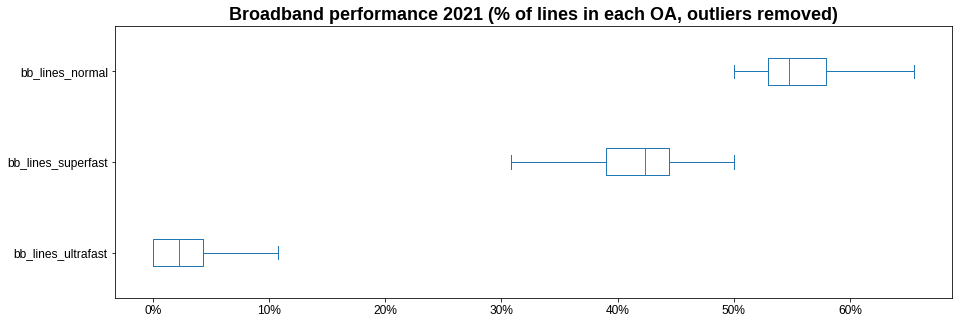

In [10]:
fig, ax = plt.subplots(figsize=(15,5))


bb_adopt_tidy[['bb_lines_ultrafast', 'bb_lines_superfast', 'bb_lines_normal']].plot(kind='box', 
                                                                                    ax=ax,
                                                                                    vert=False,
                                                                                    showfliers=False,
                                                                                    title='Broadband performance 2021 (% of lines in each OA, outliers removed)')

xlabels = [f'{(x)*100:,.0f}%' for x in ax.get_xticks()]

ax.set_xticklabels(xlabels)

# Display the plot
plt.show();

#### 3.1.2. Mean and mid speed

In [11]:
# Download speed is used to measure internet performance. Median and mean are compared to see which one would be more reasonable to use. 
bb_speed = bb[['oa11', 'Median download speed (Mbit/s)','Average download speed (Mbit/s)']]
bb_speed = bb_speed.rename(columns = {'Average download speed (Mbit/s)':'bb_speed_mean','Median download speed (Mbit/s)':'bb_speed_mid'})

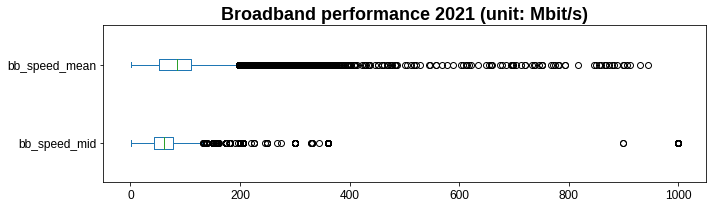

In [12]:
# boxplot is used to show distributions and compare the values between median and mean speed.
# Set the figure size
plt.rcParams["figure.figsize"] = [10,3]
plt.rcParams["figure.autolayout"] = True

# Plot the dataframe
ax = bb_speed[['bb_speed_mid', 'bb_speed_mean']].plot(kind='box',  vert=False, title='Broadband performance 2021 (unit: Mbit/s)')

# Display the plot
plt.show()

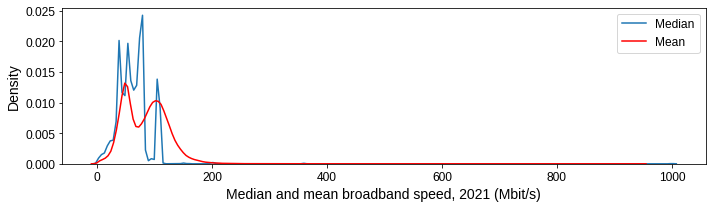

In [13]:
ax = sn.kdeplot(bb_speed.bb_speed_mid)
sn.kdeplot(bb_speed.bb_speed_mean, color='r', ax=ax)
plt.legend(loc='upper right', labels=['Median', 'Mean']) # title='Foo'
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xlabel("Median and mean broadband speed, 2021 (Mbit/s)")

plt.savefig(
    "Median_and_mean_broadband_speed_2021",
    transparent=False,
)

It seems like the average speed is slightly less skewed compared to median speed.
However, both datasets have large amount of high values. 

In [14]:
bb_speed

,oa11,bb_speed_mid,bb_speed_mean
0,E00000001,73.90,57.80
1,E00000003,78.10,62.70
2,E00000005,54.80,53.40
3,E00000007,13.80,32.80
4,E00000010,67.80,68.60
...,...,...,...
231898,W00010262,78.10,97.90
231899,W00010263,60.80,70.60
231900,W00010264,56.20,54.00
231901,W00010265,62.50,82.90


In [15]:
# drop OA with 0 speeds. 
bb_speed = bb_speed.loc[(bb_speed['bb_speed_mid']>0) | (bb_speed['bb_speed_mean']>0)]
bb_speed

,oa11,bb_speed_mid,bb_speed_mean
0,E00000001,73.90,57.80
1,E00000003,78.10,62.70
2,E00000005,54.80,53.40
3,E00000007,13.80,32.80
4,E00000010,67.80,68.60
...,...,...,...
231898,W00010262,78.10,97.90
231899,W00010263,60.80,70.60
231900,W00010264,56.20,54.00
231901,W00010265,62.50,82.90


all above 0.

In [16]:
# select mean speed for analysis
bb_meanspeed = bb_speed[['oa11', 'bb_speed_mean']]
bb_midspeed = bb_speed[['oa11', 'bb_speed_mid']]

In [17]:
# get dummies for speed
bb_meanspeed['bb_speed_ultrafast'] = np.where(bb_meanspeed['bb_speed_mean'] >= 300, 1, 0)
bb_meanspeed['bb_speed_superfast'] = np.where((bb_meanspeed.bb_speed_mean<300) & (bb_meanspeed.bb_speed_mean>=30), 1, 0)
bb_meanspeed['bb_speed_normal'] = np.where(bb_meanspeed['bb_speed_mean'] < 30, 1, 0)
bb_meanspeed['ln_bb_speed_mean'] = np.log(bb_meanspeed.bb_speed_mean)

bb_meanspeed = bb_meanspeed.set_index('oa11')
bb_meanspeed.head()

,bb_speed_mean,bb_speed_ultrafast,bb_speed_superfast,bb_speed_normal,ln_bb_speed_mean
oa11,,,,,
E00000001,57.80,0,1,0,4.06
E00000003,62.70,0,1,0,4.14
E00000005,53.40,0,1,0,3.98
E00000007,32.80,0,1,0,3.49
E00000010,68.60,0,1,0,4.23


In [18]:
# get dummies for speed
bb_midspeed['bb_speed_mid_ultrafast'] = np.where(bb_midspeed['bb_speed_mid'] >= 300, 1, 0)
bb_midspeed['bb_speed_mid_superfast'] = np.where((bb_midspeed.bb_speed_mid<300) & (bb_midspeed.bb_speed_mid>=30), 1, 0)
bb_midspeed['bb_speed_mid_normal'] = np.where(bb_midspeed['bb_speed_mid'] < 30, 1, 0)
bb_midspeed['ln_bb_speed_mid'] = np.log(bb_midspeed.bb_speed_mid)
bb_midspeed['type'] = np.where(bb_midspeed['bb_speed_mid'] >= 300, 'ultrafast', 
                                   np.where((bb_midspeed.bb_speed_mid<300) & (bb_midspeed.bb_speed_mid>=30), 'superfast',
                                            np.where(bb_midspeed['bb_speed_mid'] < 30, 'normal', 0)))

bb_midspeed['type'] = bb_midspeed['type'].astype('category')

bb_midspeed = bb_midspeed.set_index('oa11')
bb_midspeed.describe()

,bb_speed_mid,bb_speed_mid_ultrafast,bb_speed_mid_superfast,bb_speed_mid_normal,ln_bb_speed_mid
count,"231,903.00","231,903.00","231,903.00","231,903.00","231,903.00"
mean,63.48,0.00,0.93,0.07,4.05
std,30.45,0.03,0.26,0.25,0.50
min,0.50,0.00,0.00,0.00,-0.69
25%,43.50,0.00,1.00,0.00,3.77
50%,61.60,0.00,1.00,0.00,4.12
75%,78.10,0.00,1.00,0.00,4.36
max,"1,000.00",1.00,1.00,1.00,6.91


### 3.2. Region data

In [19]:
lb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2536221 entries, 0 to 2536220
Data columns (total 11 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   OA        object
 1   PCD       object
 2   PCD2      object
 3   PCDS      object
 4   LA_CODE   object
 5   LA_NAME   object
 6   REG_CODE  object
 7   REG_NAME  object
 8   SPRGRP    int64 
 9   GRP       object
 10  SUBGRP    object
dtypes: int64(1), object(10)
memory usage: 212.8+ MB


In [20]:
lb_region = lb[['OA', 'REG_NAME']]
print(lb_region.count())
lb_region = lb_region.drop_duplicates()
print(lb_region.count())
lb_region.head()

OA          2536221
REG_NAME    2536221
dtype: int64
OA          232011
REG_NAME    232011
dtype: int64


,OA,REG_NAME
0,E00000001,London
3,E00000003,London
4,E00000005,London
9,E00000007,London
113,E00000010,London


In [21]:
lb_region['REG_NAME'] = lb_region['REG_NAME'].astype('category')
lb_region.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232011 entries, 0 to 2536216
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   OA        232011 non-null  object  
 1   REG_NAME  232011 non-null  category
dtypes: category(1), object(1)
memory usage: 3.8+ MB


In [22]:
lb_region['London'] = np.where(lb_region['REG_NAME'] == 'London', 1, 0)
lb_region['NorthWest'] = np.where(lb_region['REG_NAME'] == 'North West', 1, 0)
lb_region['YorkshireandTheHumber'] = np.where(lb_region['REG_NAME'] == 'Yorkshire and The Humber', 1, 0)
lb_region['NorthEast'] = np.where(lb_region['REG_NAME'] == 'North East', 1, 0)
lb_region['WestMidlands'] = np.where(lb_region['REG_NAME'] == 'West Midlands', 1, 0)
lb_region['EastMidlands'] = np.where(lb_region['REG_NAME'] == 'East Midlands', 1, 0)
lb_region['SouthWest'] = np.where(lb_region['REG_NAME'] == 'South West', 1, 0)
lb_region['EastofEngland'] = np.where(lb_region['REG_NAME'] == 'East of England', 1, 0)
lb_region['SouthEast'] = np.where(lb_region['REG_NAME'] == 'South East', 1, 0)
lb_region['Wales'] = np.where(lb_region['REG_NAME'] == 'Wales', 1, 0)

lb_region = lb_region.set_index('OA')
lb_region

,REG_NAME,London,NorthWest,YorkshireandTheHumber,NorthEast,WestMidlands,EastMidlands,SouthWest,EastofEngland,SouthEast,Wales
OA,,,,,,,,,,,
E00000001,London,1,0,0,0,0,0,0,0,0,0
E00000003,London,1,0,0,0,0,0,0,0,0,0
E00000005,London,1,0,0,0,0,0,0,0,0,0
E00000007,London,1,0,0,0,0,0,0,0,0,0
E00000010,London,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
W00010261,Wales,0,0,0,0,0,0,0,0,0,1
W00010262,Wales,0,0,0,0,0,0,0,0,0,1
W00010263,Wales,0,0,0,0,0,0,0,0,0,1


### 3.3. Economic Activity Status

In [23]:
eas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3777600 entries, 0 to 3777599
Data columns (total 5 columns):
 #   Column                                         Dtype 
---  ------                                         ----- 
 0   Output Areas Code                              object
 1   Output Areas                                   object
 2   Economic activity status (20 categories) Code  int64 
 3   Economic activity status (20 categories)       object
 4   Observation                                    int64 
dtypes: int64(2), object(3)
memory usage: 144.1+ MB


In [24]:
eas.head()

,Output Areas Code,Output Areas,Economic activity status (20 categories) Code,Economic activity status (20 categories),Observation
0,E00000001,E00000001,-8,Does not apply,15
1,E00000001,E00000001,1,Economically active (excluding full-time stude...,17
2,E00000001,E00000001,2,Economically active (excluding full-time stude...,44
3,E00000001,E00000001,3,Economically active (excluding full-time stude...,1
4,E00000001,E00000001,4,Economically active (excluding full-time stude...,7


In [25]:
eas = eas.drop('Output Areas',axis=1).rename(columns = {'Output Areas Code':'oa'}).rename(columns = {'Economic activity status (20 categories)':'eas','Economic activity status (20 categories) Code':'code'})

In [26]:
eas_wide = eas.pivot(index='oa', columns='eas', values='Observation')
eas_wide.describe()

eas,Does not apply,Economically Inactive: Looking after home or family,Economically active (excluding full-time students): In employment: Employee: Full-time,Economically active (excluding full-time students): In employment: Employee: Part-time,Economically active (excluding full-time students): In employment: Self-employed with employees: Full-time,Economically active (excluding full-time students): In employment: Self-employed with employees: Part-time,Economically active (excluding full-time students): In employment: Self-employed without employees: Full-time,Economically active (excluding full-time students): In employment: Self-employed without employees: Part-time,Economically active (excluding full-time students): Unemployed: Seeking work or waiting to start a job already obtained: Available to start working within 2 weeks,Economically active and a full-time student: In employment: Employee: Full-time,Economically active and a full-time student: In employment: Employee: Part-time,Economically active and a full-time student: In employment: Self-employed with employees: Full-time,Economically active and a full-time student: In employment: Self-employed with employees: Part-time,Economically active and a full-time student: In employment: Self-employed without employees: Full-time,Economically active and a full-time student: In employment: Self-employed without employees: Part-time,Economically active and a full-time student: Unemployed: Seeking work or waiting to start a job already obtained: Available to start working within 2 weeks,Economically inactive: Long-term sick or disabled,Economically inactive: Other,Economically inactive: Retired,Economically inactive: Student
count,"188,880.00","188,880.00","188,880.00","188,880.00","188,880.00","188,880.00","188,880.00","188,880.00","188,880.00","188,880.00","188,880.00","188,880.00","188,880.00","188,880.00","188,880.00","188,880.00","188,880.00","188,880.00","188,880.00","188,880.00"
mean,58.40,12.27,87.80,30.60,2.99,0.93,11.54,8.89,7.29,0.78,3.17,0.02,0.02,0.08,0.24,1.58,10.73,8.05,55.66,14.51
std,30.23,8.93,35.19,11.17,2.73,1.26,6.55,5.49,5.48,1.61,5.92,0.15,0.18,0.36,0.94,5.48,9.36,14.09,31.81,41.31
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,38.00,7.00,66.00,23.00,1.00,0.00,7.00,5.00,4.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,4.00,4.00,32.00,6.00
50%,54.00,10.00,84.00,30.00,2.00,1.00,11.00,8.00,6.00,0.00,2.00,0.00,0.00,0.00,0.00,1.00,8.00,7.00,51.00,10.00
75%,73.00,15.00,105.00,37.00,4.00,1.00,15.00,12.00,10.00,1.00,4.00,0.00,0.00,0.00,0.00,2.00,15.00,10.00,76.00,15.00
max,692.00,129.00,"1,436.00",216.00,40.00,22.00,127.00,76.00,145.00,258.00,410.00,22.00,11.00,36.00,90.00,560.00,256.00,"2,428.00",359.00,"3,375.00"


In [27]:
eas_wide.columns

Index(['Does not apply', 'Economically Inactive: Looking after home or family',
       'Economically active (excluding full-time students): In employment: Employee: Full-time',
       'Economically active (excluding full-time students): In employment: Employee: Part-time',
       'Economically active (excluding full-time students): In employment: Self-employed with employees: Full-time',
       'Economically active (excluding full-time students): In employment: Self-employed with employees: Part-time',
       'Economically active (excluding full-time students): In employment: Self-employed without employees: Full-time',
       'Economically active (excluding full-time students): In employment: Self-employed without employees: Part-time',
       'Economically active (excluding full-time students): Unemployed: Seeking work or waiting to start a job already obtained: Available to start working within 2 weeks',
       'Economically active and a full-time student: In employment: Employee: F

In [28]:
eas_wide.columns = eas_wide.columns.str.lower().str.replace(' ','_')
eas_wide.columns

Index(['does_not_apply', 'economically_inactive:_looking_after_home_or_family',
       'economically_active_(excluding_full-time_students):_in_employment:_employee:_full-time',
       'economically_active_(excluding_full-time_students):_in_employment:_employee:_part-time',
       'economically_active_(excluding_full-time_students):_in_employment:_self-employed_with_employees:_full-time',
       'economically_active_(excluding_full-time_students):_in_employment:_self-employed_with_employees:_part-time',
       'economically_active_(excluding_full-time_students):_in_employment:_self-employed_without_employees:_full-time',
       'economically_active_(excluding_full-time_students):_in_employment:_self-employed_without_employees:_part-time',
       'economically_active_(excluding_full-time_students):_unemployed:_seeking_work_or_waiting_to_start_a_job_already_obtained:_available_to_start_working_within_2_weeks',
       'economically_active_and_a_full-time_student:_in_employment:_employee:_f

In [29]:
eas_wide.head()

eas,does_not_apply,economically_inactive:_looking_after_home_or_family,economically_active_(excluding_full-time_students):_in_employment:_employee:_full-time,economically_active_(excluding_full-time_students):_in_employment:_employee:_part-time,economically_active_(excluding_full-time_students):_in_employment:_self-employed_with_employees:_full-time,economically_active_(excluding_full-time_students):_in_employment:_self-employed_with_employees:_part-time,economically_active_(excluding_full-time_students):_in_employment:_self-employed_without_employees:_full-time,economically_active_(excluding_full-time_students):_in_employment:_self-employed_without_employees:_part-time,economically_active_(excluding_full-time_students):_unemployed:_seeking_work_or_waiting_to_start_a_job_already_obtained:_available_to_start_working_within_2_weeks,economically_active_and_a_full-time_student:_in_employment:_employee:_full-time,economically_active_and_a_full-time_student:_in_employment:_employee:_part-time,economically_active_and_a_full-time_student:_in_employment:_self-employed_with_employees:_full-time,economically_active_and_a_full-time_student:_in_employment:_self-employed_with_employees:_part-time,economically_active_and_a_full-time_student:_in_employment:_self-employed_without_employees:_full-time,economically_active_and_a_full-time_student:_in_employment:_self-employed_without_employees:_part-time,economically_active_and_a_full-time_student:_unemployed:_seeking_work_or_waiting_to_start_a_job_already_obtained:_available_to_start_working_within_2_weeks,economically_inactive:_long-term_sick_or_disabled,economically_inactive:_other,economically_inactive:_retired,economically_inactive:_student
oa,,,,,,,,,,,,,,,,,,,,
E00000001,15,2,44,17,7,1,9,10,10,0,0,0,0,0,0,0,1,3,52,5
E00000003,36,6,73,17,9,1,16,18,5,0,1,0,0,0,0,0,0,1,57,19
E00000005,7,3,38,7,6,0,10,4,3,0,1,0,0,0,0,0,1,6,23,3
E00000007,5,1,87,7,1,0,6,8,1,0,0,0,0,0,0,0,1,2,17,11
E00000010,7,0,66,11,3,0,15,15,18,0,0,0,0,1,0,0,9,9,15,8


In [30]:
eas_tidy = eas_wide.copy()
eas_tidy['eas_total'] = eas_wide.sum(axis=1)
eas_tidy['eas_active_total'] = eas_wide.iloc[:,2:16].sum(axis=1)
eas_tidy['eas_inactive_total'] = eas_wide.iloc[:,[1,16,17,18,19]].sum(axis=1)
eas_tidy['eas_unemploy_total'] = eas_wide.iloc[:,[8,15]].sum(axis=1)
eas_tidy['eas_unemploy'] = eas_tidy.eas_unemploy_total / eas_tidy.eas_active_total
eas_tidy['eas_employ'] = 1 - eas_tidy.eas_unemploy
eas_tidy['eas_inactive'] = eas_tidy.eas_inactive_total / eas_tidy.eas_total
eas_tidy = eas_tidy.drop(['does_not_apply', 'economically_inactive:_looking_after_home_or_family',
       'economically_active_(excluding_full-time_students):_in_employment:_employee:_full-time',
       'economically_active_(excluding_full-time_students):_in_employment:_employee:_part-time',
       'economically_active_(excluding_full-time_students):_in_employment:_self-employed_with_employees:_full-time',
       'economically_active_(excluding_full-time_students):_in_employment:_self-employed_with_employees:_part-time',
       'economically_active_(excluding_full-time_students):_in_employment:_self-employed_without_employees:_full-time',
       'economically_active_(excluding_full-time_students):_in_employment:_self-employed_without_employees:_part-time',
       'economically_active_(excluding_full-time_students):_unemployed:_seeking_work_or_waiting_to_start_a_job_already_obtained:_available_to_start_working_within_2_weeks',
       'economically_active_and_a_full-time_student:_in_employment:_employee:_full-time',
       'economically_active_and_a_full-time_student:_in_employment:_employee:_part-time',
       'economically_active_and_a_full-time_student:_in_employment:_self-employed_with_employees:_full-time',
       'economically_active_and_a_full-time_student:_in_employment:_self-employed_with_employees:_part-time',
       'economically_active_and_a_full-time_student:_in_employment:_self-employed_without_employees:_full-time',
       'economically_active_and_a_full-time_student:_in_employment:_self-employed_without_employees:_part-time',
       'economically_active_and_a_full-time_student:_unemployed:_seeking_work_or_waiting_to_start_a_job_already_obtained:_available_to_start_working_within_2_weeks',
       'economically_inactive:_long-term_sick_or_disabled',
       'economically_inactive:_other', 'economically_inactive:_retired',
       'economically_inactive:_student'], axis=1)
eas_tidy.head()

eas,eas_total,eas_active_total,eas_inactive_total,eas_unemploy_total,eas_unemploy,eas_employ,eas_inactive
oa,,,,,,,
E00000001,176,98,63,10,0.10,0.90,0.36
E00000003,259,140,83,5,0.04,0.96,0.32
E00000005,112,69,36,3,0.04,0.96,0.32
E00000007,147,110,32,1,0.01,0.99,0.22
E00000010,177,129,41,18,0.14,0.86,0.23


In [31]:
eas_tidy.describe()

eas,eas_total,eas_active_total,eas_inactive_total,eas_unemploy_total,eas_unemploy,eas_employ,eas_inactive
count,"188,880.00","188,880.00","188,880.00","188,880.00","188,880.00","188,880.00","188,880.00"
mean,315.54,155.92,101.21,8.87,0.06,0.94,0.33
std,94.91,51.16,52.28,8.06,0.04,0.04,0.11
min,96.00,2.00,2.00,0.00,0.00,0.38,0.01
25%,263.00,124.00,78.00,5.00,0.03,0.93,0.26
50%,306.00,152.00,98.00,7.00,0.05,0.95,0.32
75%,355.00,182.00,119.00,11.00,0.07,0.97,0.38
max,"4,502.00","1,679.00","3,394.00",567.00,0.62,1.00,0.99


In [32]:
eas_tidy.loc[eas_tidy['eas_inactive'] == eas_tidy.eas_inactive.max()]

eas,eas_total,eas_active_total,eas_inactive_total,eas_unemploy_total,eas_unemploy,eas_employ,eas_inactive
oa,,,,,,,
E00183708,282,4,278,0,0.00,1.00,0.99


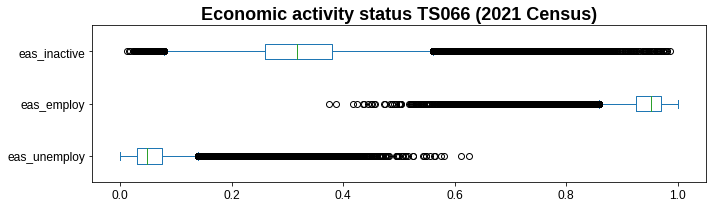

In [33]:
# boxplot
# Set the figure size
plt.rcParams["figure.figsize"] = [10,3]
plt.rcParams["figure.autolayout"] = True

# Plot the dataframe
ax = eas_tidy[['eas_unemploy', 'eas_employ','eas_inactive']].plot(kind='box',  vert=False, title='Economic activity status TS066 (2021 Census)')

# Display the plot
plt.show()

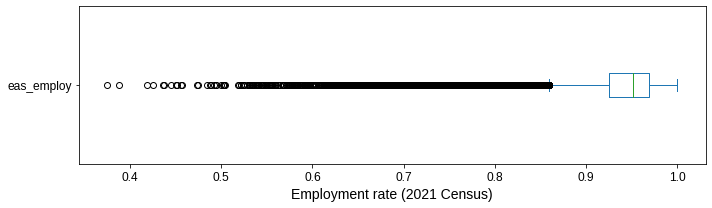

In [34]:
# boxplot
# Set the figure size
plt.rcParams["figure.figsize"] = [10,3]
plt.rcParams["figure.autolayout"] = True

# Plot the dataframe
ax = eas_tidy[['eas_employ']].plot(kind='box',  vert=False)
ax.set_xlabel('Employment rate (2021 Census)')

# Display the plot
plt.savefig(
    "Employment_2021rate_2021",
    transparent=False,
)
plt.show()



count   188,880.00
mean          0.94
std           0.04
min           0.38
25%           0.93
50%           0.95
75%           0.97
max           1.00
Name: eas_employ, dtype: float64

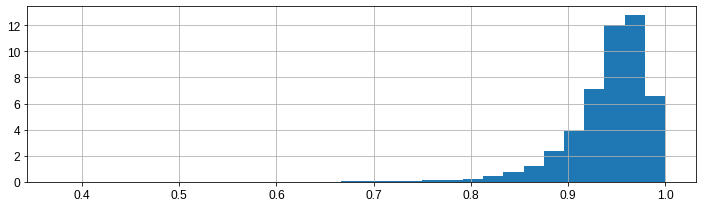

In [35]:
eas_tidy['eas_employ'].hist(bins=30, density=True)
eas_tidy['eas_employ'].describe()


### 3.4. Urban rural classification

As the rural urban classification data is in the smallest unit of LSOA, this project will link each OA to its LSOA and join the LSOA attribute in terms of rural/urban to OAs. 

In [36]:
lsoa

,OA21CD,LSOA21CD,LSOA21NM,MSOA21CD,MSOA21NM,LEP21CD1,LEP21NM1,LEP21CD2,LEP21NM2,LAD22CD,LAD22NM,ObjectId
0,E00060358,E01011968,Hartlepool 014D,E02006909,Hartlepool 014,E37000034,Tees Valley,NaN,NaN,E06000001,Hartlepool,1
1,E00060359,E01011968,Hartlepool 014D,E02006909,Hartlepool 014,E37000034,Tees Valley,NaN,NaN,E06000001,Hartlepool,2
2,E00060360,E01011968,Hartlepool 014D,E02006909,Hartlepool 014,E37000034,Tees Valley,NaN,NaN,E06000001,Hartlepool,3
3,E00060361,E01011968,Hartlepool 014D,E02006909,Hartlepool 014,E37000034,Tees Valley,NaN,NaN,E06000001,Hartlepool,4
4,E00060362,E01011970,Hartlepool 001C,E02002483,Hartlepool 001,E37000034,Tees Valley,NaN,NaN,E06000001,Hartlepool,5
...,...,...,...,...,...,...,...,...,...,...,...,...
178600,E00024093,E01004756,Westminster 006E,E02000965,Westminster 006,E37000051,London,NaN,NaN,E09000033,Westminster,178601
178601,E00024094,E01004756,Westminster 006E,E02000965,Westminster 006,E37000051,London,NaN,NaN,E09000033,Westminster,178602
178602,E00024095,E01004756,Westminster 006E,E02000965,Westminster 006,E37000051,London,NaN,NaN,E09000033,Westminster,178603
178603,E00024096,E01004755,Westminster 010B,E02000969,Westminster 010,E37000051,London,NaN,NaN,E09000033,Westminster,178604


In [37]:
lsoa2 = lsoa[['OA21CD','LSOA21CD']]

In [38]:
ru

,FID,LSOA11CD,LSOA11NM,RUC11CD,RUC11
0,1,E01000205,Barnet 035A,A1,Urban major conurbation
1,2,E01000001,City of London 001A,A1,Urban major conurbation
2,3,E01000206,Barnet 033B,A1,Urban major conurbation
3,4,E01000207,Barnet 033C,A1,Urban major conurbation
4,5,E01000002,City of London 001B,A1,Urban major conurbation
...,...,...,...,...,...
34748,34749,W01001645,Newport 015D,C1,Urban city and town
34749,34750,W01001646,Newport 015E,C1,Urban city and town
34750,34751,W01001647,Newport 015F,C1,Urban city and town
34751,34752,W01001648,Newport 015G,C1,Urban city and town


In [39]:
ru2 = ru[['LSOA11CD','RUC11CD']]

In [40]:
cl = ru[['RUC11CD','RUC11']].drop_duplicates()
cl

,RUC11CD,RUC11
0,A1,Urban major conurbation
451,C1,Urban city and town
783,E1,Rural village and dispersed
2159,D1,Rural town and fringe
6853,B1,Urban minor conurbation
13522,E2,Rural village and dispersed in a sparse setting
13955,D2,Rural town and fringe in a sparse setting
13964,C2,Urban city and town in a sparse setting


In [41]:
cl.set_index('RUC11CD')

,RUC11
RUC11CD,
A1,Urban major conurbation
C1,Urban city and town
E1,Rural village and dispersed
D1,Rural town and fringe
B1,Urban minor conurbation
E2,Rural village and dispersed in a sparse setting
D2,Rural town and fringe in a sparse setting
C2,Urban city and town in a sparse setting


Join LSOA and Rural/urban classification

In [42]:
rucl = pd.merge(lsoa2,ru2, left_on='LSOA21CD', right_on='LSOA11CD', how='inner')

In [43]:
rucl = rucl.drop(columns = 'LSOA11CD')

In [44]:
rucl = rucl.set_index('OA21CD')
rucl

,LSOA21CD,RUC11CD
OA21CD,,
E00060358,E01011968,C1
E00060359,E01011968,C1
E00060360,E01011968,C1
E00060361,E01011968,C1
E00060355,E01011968,C1
...,...,...
E00024088,E01004756,A1
E00024090,E01004756,A1
E00024093,E01004756,A1


In [45]:
urbancd = ['A1','B1','C1','C2']
rucl['ru'] = np.where(rucl.RUC11CD.isin(urbancd), 'urban', 'rural')
rucl['ru'] = rucl['ru'].astype('category')

rucl.head()

,LSOA21CD,RUC11CD,ru
OA21CD,,,
E00060358,E01011968,C1,urban
E00060359,E01011968,C1,urban
E00060360,E01011968,C1,urban
E00060361,E01011968,C1,urban
E00060355,E01011968,C1,urban


In [46]:
# make into dummies
rucl['ru_urban'] = np.where(rucl.ru == 'urban', 1, 0)
rucl.ru_urban

OA21CD
E00060358    1
E00060359    1
E00060360    1
E00060361    1
E00060355    1
            ..
E00024088    1
E00024090    1
E00024093    1
E00024094    1
E00024095    1
Name: ru_urban, Length: 168999, dtype: int64

### 3.5. Household deprivation

In [47]:
dp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1133280 entries, 0 to 1133279
Data columns (total 5 columns):
 #   Column                                     Non-Null Count    Dtype 
---  ------                                     --------------    ----- 
 0   Output Areas Code                          1133280 non-null  object
 1   Output Areas                               1133280 non-null  object
 2   Household deprivation (6 categories) Code  1133280 non-null  int64 
 3   Household deprivation (6 categories)       1133280 non-null  object
 4   Observation                                1133280 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 43.2+ MB


In [48]:
dp = dp.drop('Output Areas',axis=1).rename(columns = {'Output Areas Code':'oa'}).rename(columns = {'Household deprivation (6 categories)':'dp','Household deprivation (6 categories) Code':'code'})

In [49]:
dp_wide = dp.pivot(index='oa', columns='dp', values='Observation')
dp_wide.columns = dp_wide.columns.str.lower().str.replace(' ','_')
dp_wide.head()

dp,does_not_apply,household_is_deprived_in_four_dimensions,household_is_deprived_in_one_dimension,household_is_deprived_in_three_dimensions,household_is_deprived_in_two_dimensions,household_is_not_deprived_in_any_dimension
oa,,,,,,
E00000001,0,0,22,0,3,66
E00000003,0,0,30,0,5,74
E00000005,0,0,15,0,2,48
E00000007,0,0,15,1,1,69
E00000010,0,1,56,7,22,40


In [50]:
dp_wide.columns

Index(['does_not_apply', 'household_is_deprived_in_four_dimensions',
       'household_is_deprived_in_one_dimension',
       'household_is_deprived_in_three_dimensions',
       'household_is_deprived_in_two_dimensions',
       'household_is_not_deprived_in_any_dimension'],
      dtype='object', name='dp')

In [51]:
dp_tidy = dp_wide.copy()
dp_tidy['dp_total'] = dp_wide.sum(axis=1)
dp_tidy['deptotal'] = dp_wide.iloc[:,1:5].sum(axis=1)
dp_tidy['undeptotal'] = dp_wide.iloc[:,[5]].sum(axis=1)
dp_tidy['deprived'] = dp_tidy.deptotal / dp_tidy.dp_total
dp_tidy['undeprived'] = dp_tidy.undeptotal / dp_tidy.dp_total
dp_tidy = dp_tidy.drop(['does_not_apply', 'household_is_deprived_in_four_dimensions',
       'household_is_deprived_in_one_dimension',
       'household_is_deprived_in_three_dimensions',
       'household_is_deprived_in_two_dimensions',
       'household_is_not_deprived_in_any_dimension'], axis=1)
dp_tidy.head()

dp,dp_total,deptotal,undeptotal,deprived,undeprived
oa,,,,,
E00000001,91,25,66,0.27,0.73
E00000003,109,35,74,0.32,0.68
E00000005,65,17,48,0.26,0.74
E00000007,86,17,69,0.20,0.80
E00000010,126,86,40,0.68,0.32


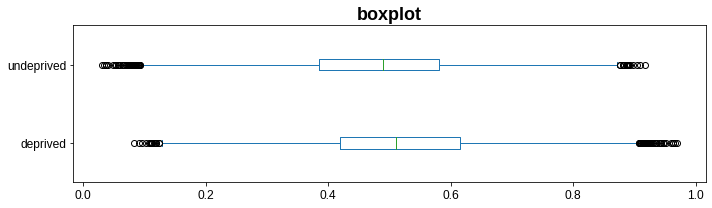

In [52]:
# boxplot
# Set the figure size
plt.rcParams["figure.figsize"] = [10, 3]
plt.rcParams["figure.autolayout"] = True

# Plot the dataframe
ax = dp_tidy[['deprived', 'undeprived']].plot(kind='box',  vert=False, title='boxplot')

# Display the plot
plt.show()

### 3.6. Ethnicity 

In [53]:
eth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3777600 entries, 0 to 3777599
Data columns (total 5 columns):
 #   Column                             Dtype 
---  ------                             ----- 
 0   Output Areas Code                  object
 1   Output Areas                       object
 2   Ethnic group (20 categories) Code  int64 
 3   Ethnic group (20 categories)       object
 4   Observation                        int64 
dtypes: int64(2), object(3)
memory usage: 144.1+ MB


In [54]:
eth = eth.drop('Output Areas',axis=1).rename(columns = {'Output Areas Code':'oa'}).rename(columns = {'Ethnic group (20 categories)':'eth','Ethnic group (20 categories) Code':'code'})

In [55]:
eth_wide = eth.pivot(index='oa', columns='eth', values='Observation')
eth_wide.columns = eth_wide.columns.str.lower().str.replace(' ','_')
eth_wide.head()

eth,"asian,_asian_british_or_asian_welsh:_bangladeshi","asian,_asian_british_or_asian_welsh:_chinese","asian,_asian_british_or_asian_welsh:_indian","asian,_asian_british_or_asian_welsh:_other_asian","asian,_asian_british_or_asian_welsh:_pakistani","black,_black_british,_black_welsh,_caribbean_or_african:_african","black,_black_british,_black_welsh,_caribbean_or_african:_caribbean","black,_black_british,_black_welsh,_caribbean_or_african:_other_black",does_not_apply,mixed_or_multiple_ethnic_groups:_other_mixed_or_multiple_ethnic_groups,mixed_or_multiple_ethnic_groups:_white_and_asian,mixed_or_multiple_ethnic_groups:_white_and_black_african,mixed_or_multiple_ethnic_groups:_white_and_black_caribbean,other_ethnic_group:_any_other_ethnic_group,other_ethnic_group:_arab,"white:_english,_welsh,_scottish,_northern_irish_or_british",white:_gypsy_or_irish_traveller,white:_irish,white:_other_white,white:_roma
oa,,,,,,,,,,,,,,,,,,,,
E00000001,0,4,0,0,1,0,3,0,0,1,5,0,0,7,0,112,0,0,39,4
E00000003,0,6,11,7,0,5,0,0,0,7,6,0,0,3,1,174,0,0,35,0
E00000005,0,4,4,5,0,0,0,0,0,2,2,2,0,7,1,65,0,0,20,0
E00000007,0,16,1,7,0,2,0,0,0,1,2,1,0,3,5,62,0,4,40,0
E00000010,1,3,3,3,0,5,5,2,0,11,7,3,1,10,1,83,0,0,37,0


In [56]:
eth_wide.columns

Index(['asian,_asian_british_or_asian_welsh:_bangladeshi',
       'asian,_asian_british_or_asian_welsh:_chinese',
       'asian,_asian_british_or_asian_welsh:_indian',
       'asian,_asian_british_or_asian_welsh:_other_asian',
       'asian,_asian_british_or_asian_welsh:_pakistani',
       'black,_black_british,_black_welsh,_caribbean_or_african:_african',
       'black,_black_british,_black_welsh,_caribbean_or_african:_caribbean',
       'black,_black_british,_black_welsh,_caribbean_or_african:_other_black',
       'does_not_apply',
       'mixed_or_multiple_ethnic_groups:_other_mixed_or_multiple_ethnic_groups',
       'mixed_or_multiple_ethnic_groups:_white_and_asian',
       'mixed_or_multiple_ethnic_groups:_white_and_black_african',
       'mixed_or_multiple_ethnic_groups:_white_and_black_caribbean',
       'other_ethnic_group:_any_other_ethnic_group',
       'other_ethnic_group:_arab',
       'white:_english,_welsh,_scottish,_northern_irish_or_british',
       'white:_gypsy_or_iri

In [57]:
eth_tidy = eth_wide.copy()
eth_tidy['ethnicity_total'] = eth_wide.sum(axis=1)
eth_tidy['minoritytotal'] = eth_wide.iloc[:,0:15].sum(axis=1) - eth_wide.iloc[:,8]
eth_tidy['whitetotal'] = eth_wide.iloc[:,15:22].sum(axis=1)
eth_tidy['minority'] = eth_tidy.minoritytotal / eth_tidy.ethnicity_total
eth_tidy['white'] = eth_tidy.whitetotal / eth_tidy.ethnicity_total
eth_tidy = eth_tidy.drop(['asian,_asian_british_or_asian_welsh:_bangladeshi',
       'asian,_asian_british_or_asian_welsh:_chinese',
       'asian,_asian_british_or_asian_welsh:_indian',
       'asian,_asian_british_or_asian_welsh:_other_asian',
       'asian,_asian_british_or_asian_welsh:_pakistani',
       'black,_black_british,_black_welsh,_caribbean_or_african:_african',
       'black,_black_british,_black_welsh,_caribbean_or_african:_caribbean',
       'black,_black_british,_black_welsh,_caribbean_or_african:_other_black',
       'does_not_apply',
       'mixed_or_multiple_ethnic_groups:_other_mixed_or_multiple_ethnic_groups',
       'mixed_or_multiple_ethnic_groups:_white_and_asian',
       'mixed_or_multiple_ethnic_groups:_white_and_black_african',
       'mixed_or_multiple_ethnic_groups:_white_and_black_caribbean',
       'other_ethnic_group:_any_other_ethnic_group',
       'other_ethnic_group:_arab',
       'white:_english,_welsh,_scottish,_northern_irish_or_british',
       'white:_gypsy_or_irish_traveller', 'white:_irish', 'white:_other_white',
       'white:_roma'], axis=1)
eth_tidy.head()

eth,ethnicity_total,minoritytotal,whitetotal,minority,white
oa,,,,,
E00000001,176,21,155,0.12,0.88
E00000003,255,46,209,0.18,0.82
E00000005,112,27,85,0.24,0.76
E00000007,144,38,106,0.26,0.74
E00000010,175,55,120,0.31,0.69


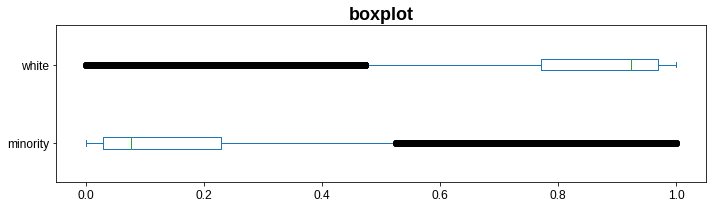

In [58]:
# boxplot
# Set the figure size
plt.rcParams["figure.figsize"] = [10, 3]
plt.rcParams["figure.autolayout"] = True

# Plot the dataframe
ax = eth_tidy[['minority', 'white']].plot(kind='box', vert=False, title='boxplot')

# Display the plot
plt.show()

### 3.7. National Statistics Socio-economic Classification (NS-SEC) data

In [59]:
nssec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1888800 entries, 0 to 1888799
Data columns (total 5 columns):
 #   Column                                                                           Dtype 
---  ------                                                                           ----- 
 0   Output Areas Code                                                                object
 1   Output Areas                                                                     object
 2   National Statistics Socio-economic Classification (NS-SeC) (10 categories) Code  int64 
 3   National Statistics Socio-economic Classification (NS-SeC) (10 categories)       object
 4   Observation                                                                      int64 
dtypes: int64(2), object(3)
memory usage: 72.1+ MB


In [60]:
nssec = nssec.drop('Output Areas',axis=1).rename(columns = {'Output Areas Code':'oa'}).rename(columns = {'National Statistics Socio-economic Classification (NS-SeC) (10 categories) Code':'code'}).rename(columns = {'National Statistics Socio-economic Classification (NS-SeC) (10 categories)':'nssec'})

In [61]:
nssec_wide = nssec.pivot(index='oa', columns='nssec', values='Observation')
nssec_wide.columns = nssec_wide.columns.str.lower().str.replace(' ','_')
nssec_wide.head()

nssec,does_not_apply,"l1,_l2_and_l3:_higher_managerial,_administrative_and_professional_occupations",l10_and_l11:_lower_supervisory_and_technical_occupations,l12:_semi-routine_occupations,l13:_routine_occupations,l14.1_and_l14.2:_never_worked_and_long-term_unemployed,l15:_full-time_students,"l4,_l5_and_l6:_lower_managerial,_administrative_and_professional_occupations",l7:_intermediate_occupations,l8_and_l9:_small_employers_and_own_account_workers
oa,,,,,,,,,,
E00000001,15,80,3,5,5,4,2,38,13,9
E00000003,36,96,2,5,2,5,20,58,8,26
E00000005,7,37,0,3,1,1,4,28,8,21
E00000007,5,62,3,3,1,6,10,39,5,11
E00000010,7,34,7,10,14,11,5,45,17,27


In [62]:
nssec_wide.columns

Index(['does_not_apply',
       'l1,_l2_and_l3:_higher_managerial,_administrative_and_professional_occupations',
       'l10_and_l11:_lower_supervisory_and_technical_occupations',
       'l12:_semi-routine_occupations', 'l13:_routine_occupations',
       'l14.1_and_l14.2:_never_worked_and_long-term_unemployed',
       'l15:_full-time_students',
       'l4,_l5_and_l6:_lower_managerial,_administrative_and_professional_occupations',
       'l7:_intermediate_occupations',
       'l8_and_l9:_small_employers_and_own_account_workers'],
      dtype='object', name='nssec')

In [63]:
nssec_tidy = nssec_wide.copy()
nssec_tidy['nssec_total'] = nssec_wide.sum(axis=1)
nssec_tidy['higher_managerial_per'] = nssec_wide.iloc[:,1] / nssec_tidy.nssec_total
nssec_tidy['lower_supervisory_per'] = nssec_wide.iloc[:,2] / nssec_tidy.nssec_total
nssec_tidy['semiroutine_per'] = nssec_tidy.iloc[:,3] / nssec_tidy.nssec_total
nssec_tidy['routine_per'] = nssec_tidy.iloc[:,4] / nssec_tidy.nssec_total
nssec_tidy['longterm_unemployed_per'] = nssec_tidy.iloc[:,5] / nssec_tidy.nssec_total
nssec_tidy['fulltime_students_per'] = nssec_tidy.iloc[:,6] / nssec_tidy.nssec_total
nssec_tidy['lower_managerial_per'] = nssec_tidy.iloc[:,7] / nssec_tidy.nssec_total
nssec_tidy['intermediate_per'] = nssec_tidy.iloc[:,8] / nssec_tidy.nssec_total
nssec_tidy['small_employers_per'] = nssec_tidy.iloc[:,9] / nssec_tidy.nssec_total

nssec_tidy = nssec_tidy.drop(['does_not_apply',
       'l1,_l2_and_l3:_higher_managerial,_administrative_and_professional_occupations',
       'l10_and_l11:_lower_supervisory_and_technical_occupations',
       'l12:_semi-routine_occupations', 'l13:_routine_occupations',
       'l14.1_and_l14.2:_never_worked_and_long-term_unemployed',
       'l15:_full-time_students',
       'l4,_l5_and_l6:_lower_managerial,_administrative_and_professional_occupations',
       'l7:_intermediate_occupations',
       'l8_and_l9:_small_employers_and_own_account_workers'], axis=1)
nssec_tidy.head()

nssec,nssec_total,higher_managerial_per,lower_supervisory_per,semiroutine_per,routine_per,longterm_unemployed_per,fulltime_students_per,lower_managerial_per,intermediate_per,small_employers_per
oa,,,,,,,,,,
E00000001,174,0.46,0.02,0.03,0.03,0.02,0.01,0.22,0.07,0.05
E00000003,258,0.37,0.01,0.02,0.01,0.02,0.08,0.22,0.03,0.10
E00000005,110,0.34,0.00,0.03,0.01,0.01,0.04,0.25,0.07,0.19
E00000007,145,0.43,0.02,0.02,0.01,0.04,0.07,0.27,0.03,0.08
E00000010,177,0.19,0.04,0.06,0.08,0.06,0.03,0.25,0.10,0.15


In [64]:
# standardize the data
mms = MinMaxScaler()

nssec_standardised = nssec_tidy.copy()
for c in nssec_tidy.columns.values:
    nssec_standardised[c] = mms.fit_transform(nssec_tidy[c].values.reshape(-1,1))
nssec_standardised.head()

nssec,nssec_total,higher_managerial_per,lower_supervisory_per,semiroutine_per,routine_per,longterm_unemployed_per,fulltime_students_per,lower_managerial_per,intermediate_per,small_employers_per
oa,,,,,,,,,,
E00000001,0.02,0.68,0.09,0.10,0.06,0.04,0.01,0.34,0.14,0.13
E00000003,0.04,0.55,0.04,0.07,0.02,0.03,0.08,0.35,0.06,0.25
E00000005,0.00,0.50,0.00,0.10,0.02,0.01,0.04,0.40,0.14,0.46
E00000007,0.01,0.63,0.10,0.07,0.02,0.07,0.07,0.42,0.06,0.18
E00000010,0.02,0.28,0.20,0.20,0.18,0.10,0.03,0.40,0.18,0.37


In [65]:
nssec_standardised.columns

Index(['nssec_total', 'higher_managerial_per', 'lower_supervisory_per',
       'semiroutine_per', 'routine_per', 'longterm_unemployed_per',
       'fulltime_students_per', 'lower_managerial_per', 'intermediate_per',
       'small_employers_per'],
      dtype='object', name='nssec')

In [66]:
# use silouette score to determine number of cluster(k)
X = nssec_standardised[['higher_managerial_per', 'lower_supervisory_per',
       'semiroutine_per', 'routine_per', 'longterm_unemployed_per',
       'fulltime_students_per', 'lower_managerial_per', 'intermediate_per',
       'small_employers_per']]
random_state_seed = 10
df_silhouette_score = pd.DataFrame({'n_cluster':[2,3,4], 'silhouette_score':[0,0,0]})
for index, row in df_silhouette_score.iterrows():
    n_clusters = row['n_cluster']
    clusterer = sklc.KMeans(n_clusters=n_clusters, random_state=random_state_seed).fit(X)
    cluster_labels = clusterer.labels_
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = sklm.silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    row['silhouette_score'] = silhouette_avg

For n_clusters = 2 The average silhouette_score is : 0.3116837599778274
For n_clusters = 3 The average silhouette_score is : 0.21592762062224638
For n_clusters = 4 The average silhouette_score is : 0.22336247382965008


In [67]:
# use silouette score to determine number of cluster(k)
X = nssec_standardised[['higher_managerial_per', 'lower_supervisory_per',
       'semiroutine_per', 'routine_per', 'longterm_unemployed_per',
       'fulltime_students_per', 'lower_managerial_per', 'intermediate_per',
       'small_employers_per']]
random_state_seed = 10
df_silhouette_score = pd.DataFrame({'n_cluster':[5,6,7], 'silhouette_score':[0,0,0]})
for index, row in df_silhouette_score.iterrows():
    n_clusters = row['n_cluster']
    clusterer = sklc.KMeans(n_clusters=n_clusters, random_state=random_state_seed).fit(X)
    cluster_labels = clusterer.labels_
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = sklm.silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    row['silhouette_score'] = silhouette_avg

For n_clusters = 5 The average silhouette_score is : 0.21253885795669472
For n_clusters = 6 The average silhouette_score is : 0.18439309389514377
For n_clusters = 7 The average silhouette_score is : 0.1885818736390133


In [68]:
# we fix the random_state so that the kmeans result is reproducible
num_clusters = 2

random_state_seed = 100
kmeans_output = sklc.KMeans(n_clusters=num_clusters, random_state=random_state_seed).fit(nssec_standardised)

# Sanity check
print(kmeans_output)                                                

KMeans(n_clusters=2, random_state=100)


In [69]:
# This line creates a list giving the final cluster number of each point:
clustering_ids_kmeans = kmeans_output.labels_

# You can print the clustering IDs to get an ordered list of labels
print(clustering_ids_kmeans)

[0 0 0 ... 0 0 1]


In [70]:
# we will combine the clustering IDs to the dataframe

nssec_tidy = nssec_tidy.assign(cluster_id = clustering_ids_kmeans)

#Have a look at the result:
print(nssec_tidy)

nssec      nssec_total  higher_managerial_per  lower_supervisory_per  \
oa                                                                     
E00000001          174                   0.46                   0.02   
E00000003          258                   0.37                   0.01   
E00000005          110                   0.34                   0.00   
E00000007          145                   0.43                   0.02   
E00000010          177                   0.19                   0.04   
...                ...                    ...                    ...   
W00010693          738                   0.00                   0.01   
W00010694          404                   0.09                   0.06   
W00010695          195                   0.06                   0.06   
W00010696          231                   0.14                   0.04   
W00010697          266                   0.06                   0.04   

nssec      semiroutine_per  routine_per  longterm_unemployed_pe

In [71]:
# These lines calculate the silhouette score...
silhouette_kmeans = sklm.silhouette_score(nssec_standardised,clustering_ids_kmeans)

# ... and print it:
print("Silhouette Score:", silhouette_kmeans)

Silhouette Score: 0.31023183169856455


In [72]:
nssec_tidy['cluster_id'].value_counts() 

1    97842
0    91038
Name: cluster_id, dtype: int64

In [73]:
kmeans_output

KMeans(n_clusters=2, random_state=100)

In [74]:
center=pd.DataFrame(kmeans_output.cluster_centers_,columns=[' nssec_total','higher_managerial_per', 'lower_supervisory_per',
       'semiroutine_per', 'routine_per', 'longterm_unemployed_per',
       'fulltime_students_per', 'lower_managerial_per', 'intermediate_per',
       'small_employers_per'])

In [75]:
center

,nssec_total,higher_managerial_per,lower_supervisory_per,semiroutine_per,routine_per,longterm_unemployed_per,fulltime_students_per,lower_managerial_per,intermediate_per,small_employers_per
0,0.05,0.24,0.18,0.24,0.13,0.08,0.06,0.32,0.18,0.24
1,0.05,0.09,0.28,0.43,0.31,0.15,0.05,0.20,0.17,0.19


In [76]:
center.iloc[0]

 nssec_total              0.05
higher_managerial_per     0.24
lower_supervisory_per     0.18
semiroutine_per           0.24
routine_per               0.13
longterm_unemployed_per   0.08
fulltime_students_per     0.06
lower_managerial_per      0.32
intermediate_per          0.18
small_employers_per       0.24
Name: 0, dtype: float64

In [77]:
center.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0    nssec_total             2 non-null      float64
 1   higher_managerial_per    2 non-null      float64
 2   lower_supervisory_per    2 non-null      float64
 3   semiroutine_per          2 non-null      float64
 4   routine_per              2 non-null      float64
 5   longterm_unemployed_per  2 non-null      float64
 6   fulltime_students_per    2 non-null      float64
 7   lower_managerial_per     2 non-null      float64
 8   intermediate_per         2 non-null      float64
 9   small_employers_per      2 non-null      float64
dtypes: float64(10)
memory usage: 288.0 bytes


In [78]:
radar = center.drop([' nssec_total'],axis=1)

In [79]:
radar['cluster'] = ['Managerial_cluster', 'Maunal_cluster']
radar

,higher_managerial_per,lower_supervisory_per,semiroutine_per,routine_per,longterm_unemployed_per,fulltime_students_per,lower_managerial_per,intermediate_per,small_employers_per,cluster
0,0.24,0.18,0.24,0.13,0.08,0.06,0.32,0.18,0.24,Managerial_cluster
1,0.09,0.28,0.43,0.31,0.15,0.05,0.20,0.17,0.19,Maunal_cluster


In [80]:
center.iloc[1]

 nssec_total              0.05
higher_managerial_per     0.09
lower_supervisory_per     0.28
semiroutine_per           0.43
routine_per               0.31
longterm_unemployed_per   0.15
fulltime_students_per     0.05
lower_managerial_per      0.20
intermediate_per          0.17
small_employers_per       0.19
Name: 1, dtype: float64

Cluster 0 is OA that residents are in more managerial positions, while cluster 1 is OA with more routine and low skill jobs. 

### 3.8. Education

In [81]:
edu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511040 entries, 0 to 1511039
Data columns (total 5 columns):
 #   Column                                              Non-Null Count    Dtype 
---  ------                                              --------------    ----- 
 0   Output Areas Code                                   1511040 non-null  object
 1   Output Areas                                        1511040 non-null  object
 2   Highest level of qualification (8 categories) Code  1511040 non-null  int64 
 3   Highest level of qualification (8 categories)       1511040 non-null  object
 4   Observation                                         1511040 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 57.6+ MB


In [82]:
edu = edu.drop('Output Areas',axis=1).rename(columns = {'Output Areas Code':'oa'}).rename(columns = {'Highest level of qualification (8 categories) Code':'code'}).rename(columns = {'Highest level of qualification (8 categories)':'edu'})

In [83]:
edu_wide = edu.pivot(index='oa', columns='edu', values='Observation')
edu_wide.columns = edu_wide.columns.str.lower().str.replace(' ','_')
edu_wide.head()

edu,apprenticeship,does_not_apply,"level_1_and_entry_level_qualifications:_1_to_4_gcses_grade_a*_to_c_,_any_gcses_at_other_grades,_o_levels_or_cses_(any_grades),_1_as_level,_nvq_level_1,_foundation_gnvq,_basic_or_essential_skills","level_2_qualifications:_5_or_more_gcses_(a*_to_c_or_9_to_4),_o_levels_(passes),_cses_(grade_1),_school_certification,_1_a_level,_2_to_3_as_levels,_vces,_intermediate_or_higher_diploma,_welsh_baccalaureate_intermediate_diploma,_nvq_level_2,_intermediate_gnvq,_city_and_guilds_craft,_btec_first_or_general_diploma,_rsa_diploma","level_3_qualifications:_2_or_more_a_levels_or_vces,_4_or_more_as_levels,_higher_school_certificate,_progression_or_advanced_diploma,_welsh_baccalaureate_advance_diploma,_nvq_level_3;_advanced_gnvq,_city_and_guilds_advanced_craft,_onc,_ond,_btec_national,_rsa_advanced_diploma","level_4_qualifications_and_above:_degree_(ba,_bsc),_higher_degree_(ma,_phd,_pgce),_nvq_level_4_to_5,_hnc,_hnd,_rsa_higher_diploma,_btec_higher_level,_professional_qualifications_(for_example,_teaching,_nursing,_accountancy)",no_qualifications,"other:_vocational_or_work-related_qualifications,_other_qualifications_achieved_in_england_or_wales,_qualifications_achieved_outside_england_or_wales_(equivalent_not_stated_or_unknown)"
oa,,,,,,,,
E00000001,1,15,7,10,11,122,4,5
E00000003,1,36,3,8,20,184,5,0
E00000005,3,7,2,3,7,88,3,0
E00000007,1,5,2,5,7,117,5,2
E00000010,0,7,15,18,23,93,15,8


In [154]:
edu_wide.columns.to_list()

['apprenticeship',
 'does_not_apply',
 'level_1_and_entry_level_qualifications:_1_to_4_gcses_grade_a*_to_c_,_any_gcses_at_other_grades,_o_levels_or_cses_(any_grades),_1_as_level,_nvq_level_1,_foundation_gnvq,_basic_or_essential_skills',
 'level_2_qualifications:_5_or_more_gcses_(a*_to_c_or_9_to_4),_o_levels_(passes),_cses_(grade_1),_school_certification,_1_a_level,_2_to_3_as_levels,_vces,_intermediate_or_higher_diploma,_welsh_baccalaureate_intermediate_diploma,_nvq_level_2,_intermediate_gnvq,_city_and_guilds_craft,_btec_first_or_general_diploma,_rsa_diploma',
 'level_3_qualifications:_2_or_more_a_levels_or_vces,_4_or_more_as_levels,_higher_school_certificate,_progression_or_advanced_diploma,_welsh_baccalaureate_advance_diploma,_nvq_level_3;_advanced_gnvq,_city_and_guilds_advanced_craft,_onc,_ond,_btec_national,_rsa_advanced_diploma',
 'level_4_qualifications_and_above:_degree_(ba,_bsc),_higher_degree_(ma,_phd,_pgce),_nvq_level_4_to_5,_hnc,_hnd,_rsa_higher_diploma,_btec_higher_level,_pr

In [155]:
edu_tidy = edu_wide.copy()
edu_tidy['edu_total'] = edu_wide.sum(axis=1)
edu_tidy['level4'] = edu_wide.iloc[:,5] / edu_tidy.edu_total
edu_tidy['level3'] = edu_wide.iloc[:,4] / edu_tidy.edu_total
edu_tidy['apprenticeship'] = edu_wide.iloc[:,0] / edu_tidy.edu_total
edu_tidy['level2'] = edu_wide.iloc[:,3] / edu_tidy.edu_total
edu_tidy['level1'] = edu_wide.iloc[:,2] / edu_tidy.edu_total
edu_tidy['no_qualifications'] = edu_wide.iloc[:,6] / edu_tidy.edu_total

edu_tidy = edu_tidy.drop(['does_not_apply',
 'level_1_and_entry_level_qualifications:_1_to_4_gcses_grade_a*_to_c_,_any_gcses_at_other_grades,_o_levels_or_cses_(any_grades),_1_as_level,_nvq_level_1,_foundation_gnvq,_basic_or_essential_skills',
 'level_2_qualifications:_5_or_more_gcses_(a*_to_c_or_9_to_4),_o_levels_(passes),_cses_(grade_1),_school_certification,_1_a_level,_2_to_3_as_levels,_vces,_intermediate_or_higher_diploma,_welsh_baccalaureate_intermediate_diploma,_nvq_level_2,_intermediate_gnvq,_city_and_guilds_craft,_btec_first_or_general_diploma,_rsa_diploma',
 'level_3_qualifications:_2_or_more_a_levels_or_vces,_4_or_more_as_levels,_higher_school_certificate,_progression_or_advanced_diploma,_welsh_baccalaureate_advance_diploma,_nvq_level_3;_advanced_gnvq,_city_and_guilds_advanced_craft,_onc,_ond,_btec_national,_rsa_advanced_diploma',
 'level_4_qualifications_and_above:_degree_(ba,_bsc),_higher_degree_(ma,_phd,_pgce),_nvq_level_4_to_5,_hnc,_hnd,_rsa_higher_diploma,_btec_higher_level,_professional_qualifications_(for_example,_teaching,_nursing,_accountancy)',
  'other:_vocational_or_work-related_qualifications,_other_qualifications_achieved_in_england_or_wales,_qualifications_achieved_outside_england_or_wales_(equivalent_not_stated_or_unknown)'], axis=1)
edu_tidy.head()

edu,apprenticeship,no_qualifications,edu_total,level4,level3,level2,level1
oa,,,,,,,
E00000001,0.01,0.02,175,0.70,0.06,0.06,0.04
E00000003,0.00,0.02,257,0.72,0.08,0.03,0.01
E00000005,0.03,0.03,113,0.78,0.06,0.03,0.02
E00000007,0.01,0.03,144,0.81,0.05,0.03,0.01
E00000010,0.00,0.08,179,0.52,0.13,0.10,0.08


In [156]:
edu_tidy.describe()

edu,apprenticeship,no_qualifications,edu_total,level4,level3,level2,level1
count,"188,880.00","188,880.00","188,880.00","188,880.00","188,880.00","188,880.00","188,880.00"
mean,0.04,0.15,315.53,0.28,0.14,0.11,0.08
std,0.02,0.07,94.91,0.12,0.05,0.03,0.03
min,0.00,0.00,97.00,0.03,0.00,0.00,0.00
25%,0.03,0.10,263.00,0.19,0.11,0.09,0.06
50%,0.04,0.14,306.00,0.26,0.13,0.11,0.08
75%,0.06,0.20,355.00,0.35,0.16,0.13,0.10
max,0.45,0.65,"4,500.00",0.89,0.88,0.49,0.33


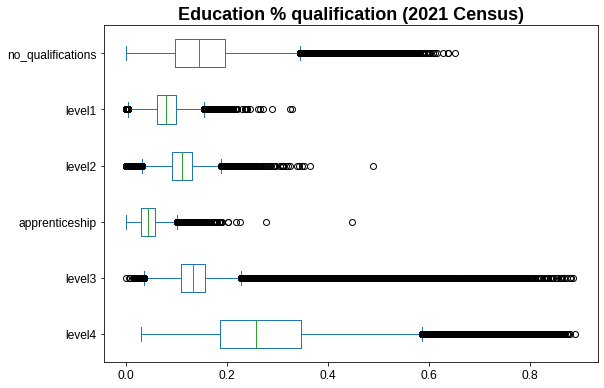

In [157]:
# boxplot
# Set the figure size
plt.rcParams["figure.figsize"] = [8.50, 5.50]
plt.rcParams["figure.autolayout"] = True

# Plot the dataframe
ax = edu_tidy[['level4', 'level3','apprenticeship', 'level2', 'level1', 'no_qualifications']].plot(kind='box', 
                                                                                              vert=False, 
                                                                                              title='Education % qualification (2021 Census)')

# Display the plot
plt.show()

In [158]:
edu_tidy['edu_index'] = edu_tidy['level4']*100+edu_tidy['level3']*80+edu_tidy['apprenticeship']*60+edu_tidy['level2']*40+edu_tidy['level1']*20

In [159]:
edu_tidy[['edu_index','level4', 'level3','level2','level1','apprenticeship']]

edu,edu_index,level4,level3,level2,level1,apprenticeship
oa,,,,,,
E00000001,78.17,0.70,0.06,0.06,0.04,0.01
E00000003,79.53,0.72,0.08,0.03,0.01,0.00
E00000005,85.84,0.78,0.06,0.03,0.02,0.03
E00000007,87.22,0.81,0.05,0.03,0.01,0.01
E00000010,67.93,0.52,0.13,0.10,0.08,0.00
...,...,...,...,...,...,...
W00010693,74.55,0.20,0.63,0.07,0.02,0.01
W00010694,52.54,0.36,0.12,0.11,0.05,0.02
W00010695,48.10,0.24,0.19,0.13,0.04,0.05


In [160]:
edu_tidy.edu_index.describe()

count   188,880.00
mean         47.25
std          11.22
min          12.49
25%          39.38
50%          46.99
75%          54.21
max          94.93
Name: edu_index, dtype: float64

### 3.9. Distance travel to work / work from home

In [161]:
dis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2077680 entries, 0 to 2077679
Data columns (total 4 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   oa           object
 1   code         int64 
 2   dis          object
 3   Observation  int64 
dtypes: int64(2), object(2)
memory usage: 63.4+ MB


In [164]:
#dis = dis.drop(' Areas',axis=1).rename(columns = {'Output Areas Code':'oa'}).rename(columns = {'Distance travelled to work (11 categories) Code':'code'}).rename(columns = {'Distance travelled to work (11 categories)':'dis'})

In [165]:
dis_wide = dis.pivot(index='oa', columns='dis', values='Observation')
dis_wide.columns = dis_wide.columns.str.lower().str.replace(' ','_')
dis_wide.head()

dis,10km_to_less_than_20km,20km_to_less_than_30km,2km_to_less_than_5km,30km_to_less_than_40km,40km_to_less_than_60km,5km_to_less_than_10km,60km_and_over,does_not_apply,less_than_2km,"works_mainly_at_an_offshore_installation,_in_no_fixed_place,_or_outside_the_uk",works_mainly_from_home
oa,,,,,,,,,,,
E00000001,2,0,7,0,1,5,1,88,8,5,59
E00000003,2,1,7,0,0,11,0,122,5,3,105
E00000005,1,0,8,0,0,3,0,46,11,6,37
E00000007,2,0,5,0,0,4,2,39,13,2,78
E00000010,4,0,9,0,0,4,1,65,29,11,55


In [166]:
dis_wide.columns

Index(['10km_to_less_than_20km', '20km_to_less_than_30km',
       '2km_to_less_than_5km', '30km_to_less_than_40km',
       '40km_to_less_than_60km', '5km_to_less_than_10km', '60km_and_over',
       'does_not_apply', 'less_than_2km',
       'works_mainly_at_an_offshore_installation,_in_no_fixed_place,_or_outside_the_uk',
       'works_mainly_from_home'],
      dtype='object', name='dis')

In [167]:
dis_tidy = dis_wide.copy()
dis_tidy['dis_total'] = dis_wide.sum(axis=1)
dis_tidy['wfh'] = dis_wide.iloc[:,10] / dis_tidy.dis_total

dis_tidy = dis_tidy.drop(['10km_to_less_than_20km', '20km_to_less_than_30km',
       '2km_to_less_than_5km', '30km_to_less_than_40km',
       '40km_to_less_than_60km', '5km_to_less_than_10km', '60km_and_over',
       'does_not_apply', 'less_than_2km',
       'works_mainly_at_an_offshore_installation,_in_no_fixed_place,_or_outside_the_uk',
       'works_mainly_from_home'], axis=1)
dis_tidy.head()

dis,dis_total,wfh
oa,,
E00000001,176,0.34
E00000003,256,0.41
E00000005,112,0.33
E00000007,145,0.54
E00000010,178,0.31


<AxesSubplot:xlabel='wfh', ylabel='eas_employ'>

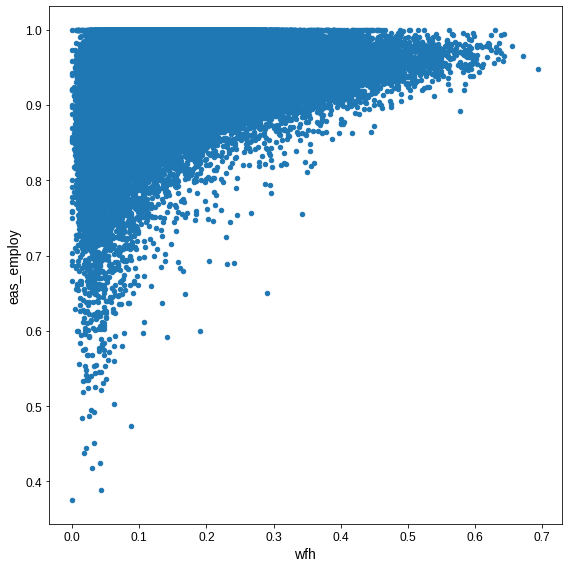

In [168]:
data0 = pd.merge(dis_tidy, bb_meanspeed, left_index=True, right_index=True, how='inner')
data0 = pd.merge(data0, eas_tidy, left_index=True, right_index=True, how='inner')

data0.plot(kind='scatter', x='wfh', y='eas_employ', figsize=(8, 8))


## 4. Join data

In [169]:
data = pd.merge(eas_tidy,bb_meanspeed, left_index=True, right_index=True, how='inner')
data = pd.merge(data,bb_midspeed, left_index=True, right_index=True, how='inner')
data = pd.merge(data, lb_region, left_index=True, right_index=True, how='inner')
data = pd.merge(data,bb_adopt_tidy, left_index=True, right_index=True, how='inner')
data = pd.merge(data,rucl, left_index=True, right_index=True, how='inner')
data = pd.merge(data, dp_tidy, left_index=True, right_index=True, how='inner')
data = pd.merge(data, eth_tidy, left_index=True, right_index=True, how='inner')
data = pd.merge(data, nssec_tidy, left_index=True, right_index=True, how='inner')
data = pd.merge(data, edu_tidy, left_index=True, right_index=True, how='inner')
data = pd.merge(data, dis_tidy, left_index=True, right_index=True, how='inner')

data

data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160329 entries, E00000001 to E00176773
Data columns (total 68 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   eas_total                160329 non-null  int64   
 1   eas_active_total         160329 non-null  int64   
 2   eas_inactive_total       160329 non-null  int64   
 3   eas_unemploy_total       160329 non-null  int64   
 4   eas_unemploy             160329 non-null  float64 
 5   eas_employ               160329 non-null  float64 
 6   eas_inactive             160329 non-null  float64 
 7   bb_speed_mean            160329 non-null  float64 
 8   bb_speed_ultrafast       160329 non-null  int64   
 9   bb_speed_superfast       160329 non-null  int64   
 10  bb_speed_normal          160329 non-null  int64   
 11  ln_bb_speed_mean         160329 non-null  float64 
 12  bb_speed_mid             160329 non-null  float64 
 13  bb_speed_mid_ultrafast   160329 non-nu

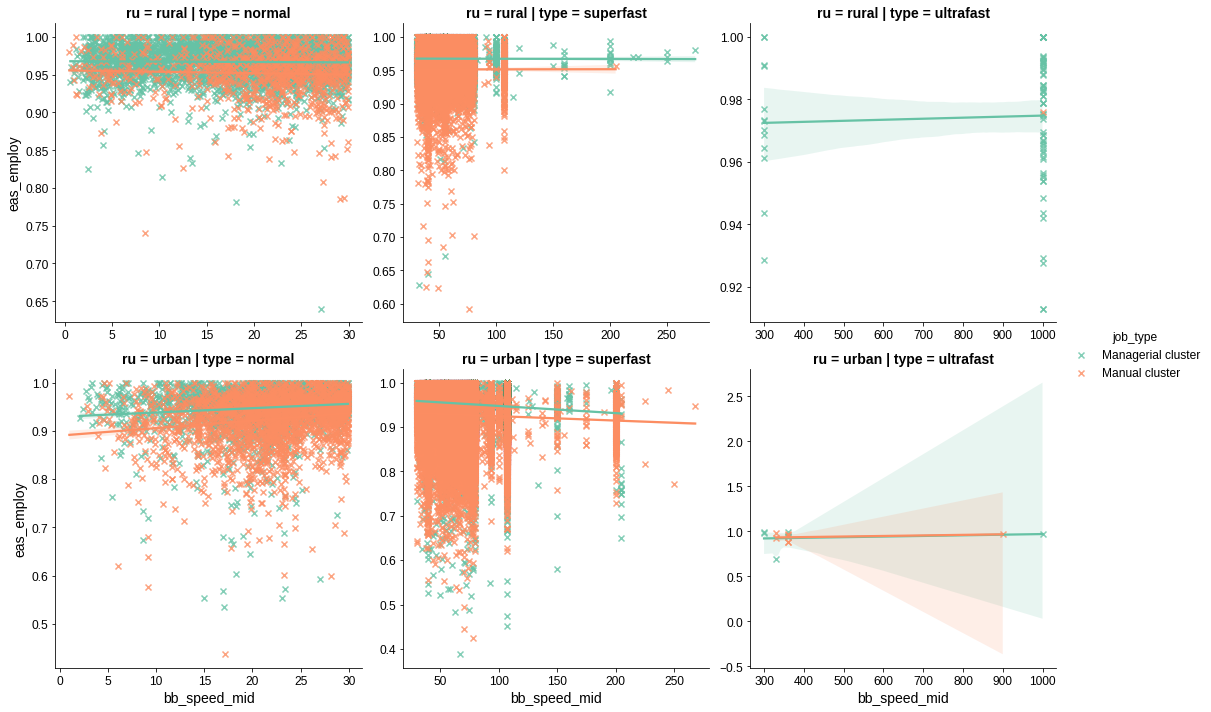

In [170]:
data['job_type'] = np.where(data.cluster_id==0, 'Managerial cluster','Manual cluster')
# library & dataset
import seaborn as sns
import matplotlib.pyplot as plt
 
# Use the 'hue' argument to provide a factor variable
sn.lmplot( x="bb_speed_mid", y="eas_employ", 
          data=data, 
          markers='x', 
          fit_reg=True, 
          col="type", row="ru",sharex=False, sharey=False,
          hue='job_type', 
          palette="Set2")
 
# Move the legend to an empty part of the plot

plt.savefig(
    "scatter_speed_employ",
    transparent=False,
)
plt.show()

## 5. Data analysis

In [171]:
data_bar = data.groupby(['RUC11CD', 'type']).size().unstack().fillna(0)


In [172]:
data_bar

type,normal,superfast,ultrafast
RUC11CD,,,
A1,1694,53956,6
B1,198,5770,0
C1,2715,67425,8
C2,24,268,0
D1,1322,13100,4
D2,68,548,3
E1,2796,9332,55
E2,311,712,14


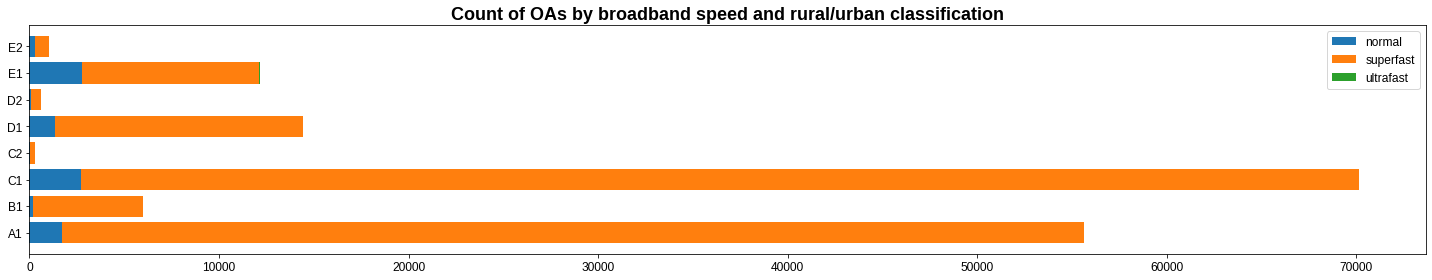

In [173]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.barh(data_bar.index, data_bar['normal'], label='normal')
ax.barh(data_bar.index, data_bar['superfast'], left=data_bar['normal'],
       label='superfast')
ax.barh(data_bar.index, data_bar['ultrafast'], left=data_bar['superfast']+data_bar['normal'],
       label='ultrafast')
ax.set_title('Count of OAs by broadband speed and rural/urban classification')
ax.legend()

In [174]:
data_bar2 = data.groupby(['type','RUC11CD']).size().unstack().fillna(0)
data_bar2

RUC11CD,A1,B1,C1,C2,D1,D2,E1,E2
type,,,,,,,,
normal,1694,198,2715,24,1322,68,2796,311
superfast,53956,5770,67425,268,13100,548,9332,712
ultrafast,6,0,8,0,4,3,55,14


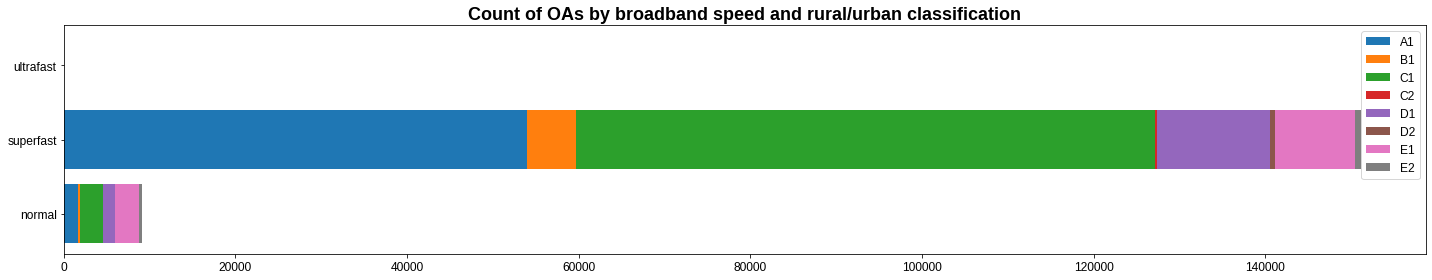

In [175]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.barh(data_bar2.index, data_bar2['A1'], label='A1')
ax.barh(data_bar2.index, data_bar2['B1'], left=data_bar2['A1'],
       label='B1')
ax.barh(data_bar2.index, data_bar2['C1'], left=data_bar2['A1']+data_bar2['B1'],
       label='C1')
ax.barh(data_bar2.index, data_bar2['C2'], left=data_bar2['A1']+data_bar2['B1']+data_bar2['C1'],
       label='C2')
ax.barh(data_bar2.index, data_bar2['D1'], left=data_bar2['A1']+data_bar2['B1']+data_bar2['C1']+data_bar2['C2'],
       label='D1')
ax.barh(data_bar2.index, data_bar2['D2'], left=data_bar2['A1']+data_bar2['B1']+data_bar2['C1']+data_bar2['C2']+data_bar2['D1'],
       label='D2')
ax.barh(data_bar2.index, data_bar2['E1'], left=data_bar2['A1']+data_bar2['B1']+data_bar2['C1']+data_bar2['C2']+data_bar2['D1']+data_bar2['D2'],
       label='E1')
ax.barh(data_bar2.index, data_bar2['E2'], left=data_bar2['A1']+data_bar2['B1']+data_bar2['C1']+data_bar2['C2']+data_bar2['D1']+data_bar2['D2']+data_bar2['E1'],
       label='E2')
ax.set_title('Count of OAs by broadband speed and rural/urban classification')
ax.legend()

Although both bar charts show similar finding that the high porprotion of OAs have superfast broadband, bar charts fail to indicate the difference of ultrafast ones as those are small percentages being less visible through this chart, so table of percentage and count would be included in the report rather than those charts. 

In [176]:
data['ln_eas_unemploy'] = np.log(data.eas_unemploy)
data['ln_eas_employ'] = np.log(data.eas_employ)
data

,eas_total,eas_active_total,eas_inactive_total,eas_unemploy_total,eas_unemploy,eas_employ,eas_inactive,bb_speed_mean,bb_speed_ultrafast,bb_speed_superfast,...,level4,level3,level2,level1,edu_index,dis_total,wfh,job_type,ln_eas_unemploy,ln_eas_employ
E00000001,176,98,63,10,0.10,0.90,0.36,57.80,0,1,...,0.70,0.06,0.06,0.04,78.17,176,0.34,Managerial cluster,-2.28,-0.11
E00000003,259,140,83,5,0.04,0.96,0.32,62.70,0,1,...,0.72,0.08,0.03,0.01,79.53,256,0.41,Managerial cluster,-3.33,-0.04
E00000005,112,69,36,3,0.04,0.96,0.32,53.40,0,1,...,0.78,0.06,0.03,0.02,85.84,112,0.33,Managerial cluster,-3.14,-0.04
E00000007,147,110,32,1,0.01,0.99,0.22,32.80,0,1,...,0.81,0.05,0.03,0.01,87.22,145,0.54,Managerial cluster,-4.70,-0.01
E00000010,177,129,41,18,0.14,0.86,0.23,68.60,0,1,...,0.52,0.13,0.10,0.08,67.93,178,0.31,Managerial cluster,-1.97,-0.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E00176769,169,128,33,12,0.09,0.91,0.20,78.90,0,1,...,0.47,0.19,0.08,0.05,68.00,163,0.35,Manual cluster,-2.37,-0.10
E00176770,142,77,35,8,0.10,0.90,0.25,79.80,0,1,...,0.21,0.18,0.10,0.12,42.84,141,0.11,Manual cluster,-2.26,-0.11
E00176771,476,175,275,47,0.27,0.73,0.58,121.80,0,1,...,0.12,0.73,0.05,0.02,73.04,476,0.08,Managerial cluster,-1.31,-0.31
E00176772,262,113,102,7,0.06,0.94,0.39,151.10,0,1,...,0.41,0.14,0.06,0.07,57.38,260,0.19,Managerial cluster,-2.78,-0.06


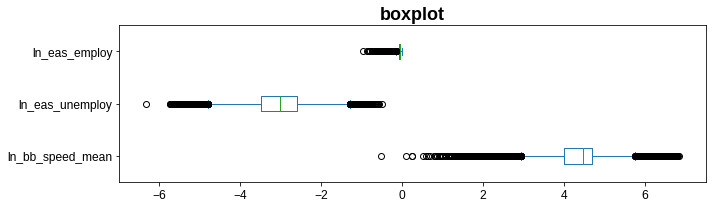

In [177]:
plt.rcParams["figure.figsize"] = [10,3]
plt.rcParams["figure.autolayout"] = True

# Plot the dataframe
ax = data[['ln_bb_speed_mean', 'ln_eas_unemploy','ln_eas_employ']].plot(kind='box',  vert=False, title='boxplot')

# Display the plot
plt.show()

<AxesSubplot:xlabel='bb_speed_mid', ylabel='eas_employ'>

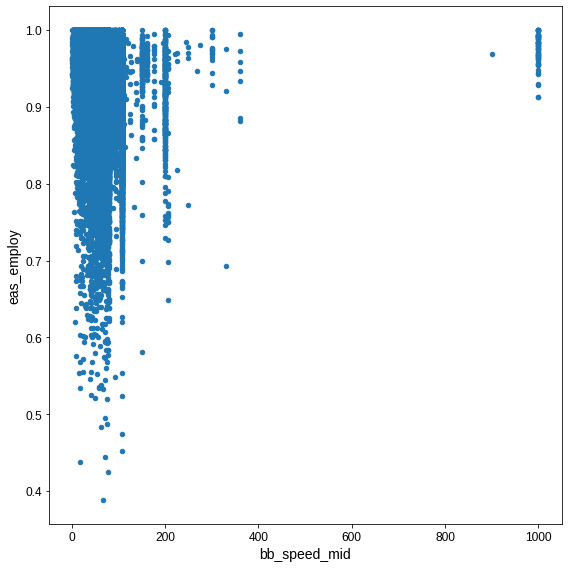

In [178]:
data.plot(kind='scatter', x='bb_speed_mid', y='eas_employ',figsize=(8, 8))

<AxesSubplot:xlabel='bb_lines_ultrafast', ylabel='eas_employ'>

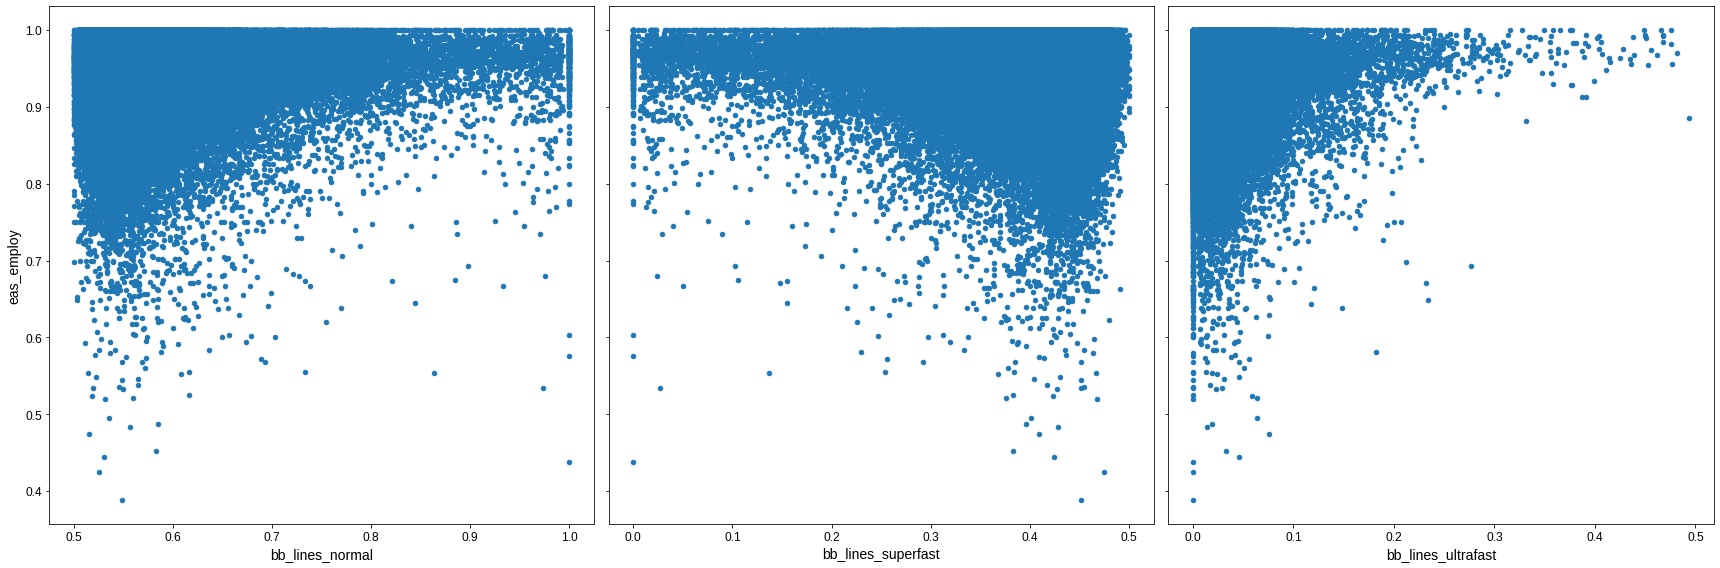

In [179]:
fig, axs = plt.subplots(1,3, sharey=True)

data.plot(kind='scatter', x='bb_lines_normal', y='eas_employ',ax=axs[0], figsize=(24, 8))
data.plot(kind='scatter', x='bb_lines_superfast', y='eas_employ',ax=axs[1])
data.plot(kind='scatter', x='bb_lines_ultrafast', y='eas_employ',ax=axs[2])


In [180]:
reg_umployper = smf.ols(formula='eas_employ ~ bb_speed_mid_superfast + bb_speed_mid_normal',data=data).fit()
print(reg_umployper.summary())

                            OLS Regression Results                            
Dep. Variable:             eas_employ   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     168.7
Date:                Mon, 16 Jan 2023   Prob (F-statistic):           6.75e-74
Time:                        05:51:51   Log-Likelihood:             2.8395e+05
No. Observations:              160329   AIC:                        -5.679e+05
Df Residuals:                  160326   BIC:                        -5.679e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

The low r squared might be explained by the single explainatory variable. The variation from best fit line is high with greater residuals when meanspeed is lower. The prediction can be problematic with low r squared. Nevertheless, p values is close to zero, indicating high significance of the prediction. Thus, more explanatory variables would be added to enhance the prediction. 

### Hypothesis 1 - KW test

#### Step 1:  Hypotheses.
- H0: The median employment rate of OAs in the same median broadband speed range is the same. 
- H1: Different median employment rate for the three speed types. 

#### Step 2: Significance level.
- 𝛂 = 0.05

#### Step 3: Evidence (The Test Statistic).


In [181]:
# Create a Pandas Data frame to hold the data for performing ANOVA.
data_anova = data[['eas_employ','bb_speed_mid_ultrafast', 'bb_speed_mid_superfast','bb_speed_mid_normal']]
data_anova

,eas_employ,bb_speed_mid_ultrafast,bb_speed_mid_superfast,bb_speed_mid_normal
E00000001,0.90,0,1,0
E00000003,0.96,0,1,0
E00000005,0.96,0,1,0
E00000007,0.99,0,0,1
E00000010,0.86,0,1,0
...,...,...,...,...
E00176769,0.91,0,0,1
E00176770,0.90,0,1,0
E00176771,0.73,0,1,0
E00176772,0.94,0,1,0


In [182]:
data_anova_normal = data_anova.loc[data_anova['bb_speed_mid_normal'] == 1].drop(columns = ['bb_speed_mid_ultrafast', 'bb_speed_mid_superfast','bb_speed_mid_normal'])
data_anova_superfast = data_anova.loc[data_anova['bb_speed_mid_superfast'] == 1].drop(columns = ['bb_speed_mid_ultrafast', 'bb_speed_mid_superfast','bb_speed_mid_normal'])
data_anova_ultrafast = data_anova.loc[data_anova['bb_speed_mid_ultrafast'] == 1].drop(columns = ['bb_speed_mid_ultrafast', 'bb_speed_mid_superfast','bb_speed_mid_normal'])

In [183]:
data_anova_normal.describe()

,eas_employ
count,"9,128.00"
mean,0.95
std,0.04
min,0.44
25%,0.94
50%,0.96
75%,0.98
max,1.00


In [184]:
data_anova_superfast.describe()

,eas_employ
count,"151,111.00"
mean,0.94
std,0.04
min,0.39
25%,0.93
50%,0.95
75%,0.97
max,1.00


In [185]:
data_anova_ultrafast.describe()

,eas_employ
count,90.00
mean,0.97
std,0.04
min,0.69
25%,0.96
50%,0.98
75%,0.99
max,1.00


In [186]:
# Check whether there is equal variance between scores of those three strategies.
n = data_anova_normal['eas_employ'].values.tolist()
s = data_anova_superfast['eas_employ'].values.tolist()
u = data_anova_ultrafast['eas_employ'].values.tolist()

stats.bartlett(n, s, u)

BartlettResult(statistic=69.57232229877148, pvalue=7.808402039649507e-16)

The p-value (7.808402039649507e-16) from Bartlett’s test is less than α = .05, which means we can reject the null hypothesis that each group has the same variance. Thus, the assumption of equal variances is violated and we can not use classic ANOVA and can proceed to perform Welch’s ANOVA.
However, this data has unequal sample size, so Welsh's ANOVA still can not be used. 

In [187]:
# basic ANOVA
#from scipy.stats import f_oneway

#f_oneway(data_anova_normal, data_anova_superfast, data_anova_ultrafast)


In [188]:
# Conduct the Kruskal-Wallis Test
result = stats.kruskal(n, s, u)
 
# Print the result
print(result)

KruskalResult(statistic=702.6889400061281, pvalue=2.588424074364746e-153)


In [189]:
data_anova_plot = data[['eas_employ','bb_speed_mid','type','RUC11CD']]
data_anova_plot

,eas_employ,bb_speed_mid,type,RUC11CD
E00000001,0.90,73.90,superfast,A1
E00000003,0.96,78.10,superfast,A1
E00000005,0.96,54.80,superfast,A1
E00000007,0.99,13.80,normal,A1
E00000010,0.86,67.80,superfast,A1
...,...,...,...,...
E00176769,0.91,22.10,normal,A1
E00176770,0.90,58.90,superfast,A1
E00176771,0.73,93.50,superfast,A1
E00176772,0.94,80.00,superfast,A1


In [190]:
data_anova_plot['RU'] = np.where((data_anova_plot.RUC11CD=='A1') | (data_anova_plot.RUC11CD=='B1') | (data_anova_plot.RUC11CD=='C1') | (data_anova_plot.RUC11CD=='C2'), 'Urban', 'Rural')

In [191]:
data_anova_plot

,eas_employ,bb_speed_mid,type,RUC11CD,RU
E00000001,0.90,73.90,superfast,A1,Urban
E00000003,0.96,78.10,superfast,A1,Urban
E00000005,0.96,54.80,superfast,A1,Urban
E00000007,0.99,13.80,normal,A1,Urban
E00000010,0.86,67.80,superfast,A1,Urban
...,...,...,...,...,...
E00176769,0.91,22.10,normal,A1,Urban
E00176770,0.90,58.90,superfast,A1,Urban
E00176771,0.73,93.50,superfast,A1,Urban
E00176772,0.94,80.00,superfast,A1,Urban


In [192]:
data_anova_plot[data_anova_plot.RU=='Urban'].describe()

,eas_employ,bb_speed_mid
count,"132,064.00","132,064.00"
mean,0.94,67.28
std,0.04,23.52
min,0.39,1.00
25%,0.92,52.00
50%,0.95,68.50
75%,0.97,78.10
max,1.00,"1,000.00"


<AxesSubplot:xlabel='type', ylabel='eas_employ'>

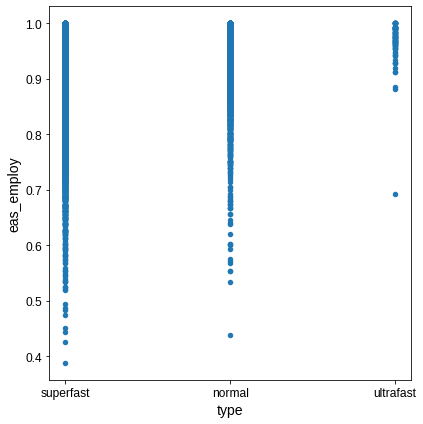

In [193]:
data_anova_plot.plot(kind='scatter', x='type', y='eas_employ',figsize=(6, 6))

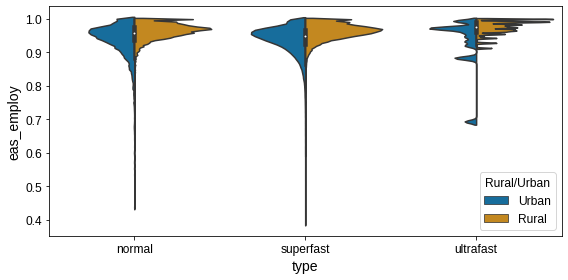

In [194]:
fig, ax = plt.subplots(figsize=(8,4))

ru_violin = sn.violinplot(data=data_anova_plot, x='type', y='eas_employ',hue='RU', split=True, bw=0.06, inner = 'box', width = 0.9, palette = 'colorblind', ax=ax)

plt.legend(loc='lower right', title='Rural/Urban')
plt.savefig('Distribution_of_employment_rate')
#ru_violin.set(ylim=(0.7,1))

#### Step 4: Probability of seeing evidence at least as extreme as Evidence, if H0 is true. (The p-value).

#### Step 5: If the p-value is smaller than the significance, reject H0 and accept H1. Otherwise there is not enough evidence to reject H0.

From KW test, p value is 2.588424074364746e-153 lower than 0.05 so we can reject null hypothesis. The median in employment rate has statistically significant difference for the three speed type. 

### Hypothesis 2 - Regression

<AxesSubplot:ylabel='Density'>

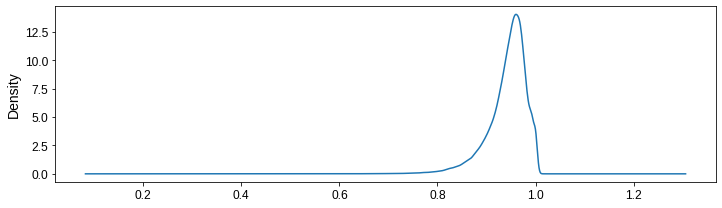

In [195]:
data['eas_employ'].plot(kind='kde')


<AxesSubplot:ylabel='Density'>

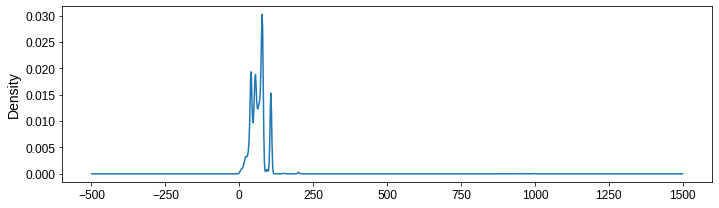

In [196]:
data['bb_speed_mid'].plot(kind='kde')


<AxesSubplot:xlabel='bb_speed_mid', ylabel='log_eas_employ'>

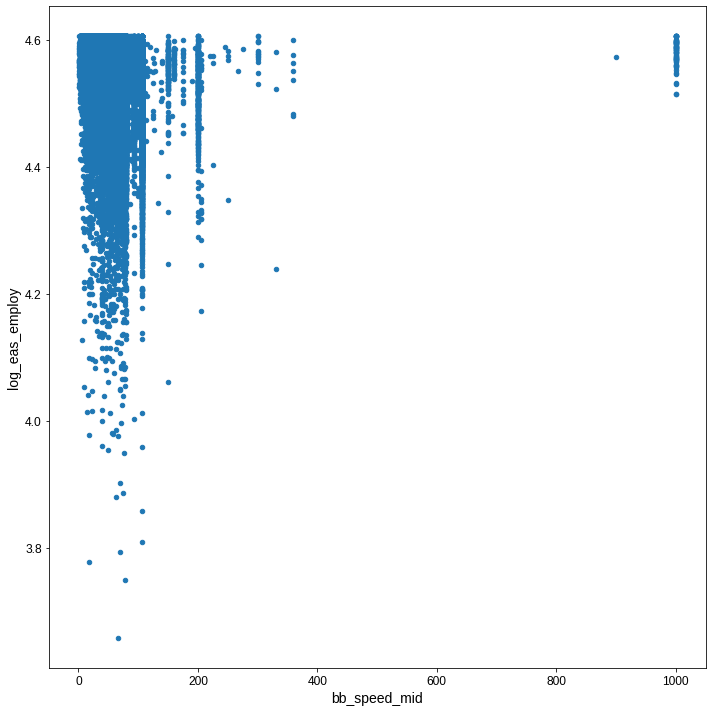

In [197]:
data['log_eas_employ'] = log(data.eas_employ*100)

data.plot(kind='scatter', x='bb_speed_mid', y='log_eas_employ',figsize=(10,10))



#### Model 1: employment and speed (numeric)

In [198]:
# This performs a multiple regression of wellbeing against greenery:

reg_epl_speed = smf.ols(formula='eas_employ ~ bb_speed_mid',data=data).fit()

# And this gives a big summary of the results:
print(reg_epl_speed.summary())

                            OLS Regression Results                            
Dep. Variable:             eas_employ   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1118.
Date:                Mon, 16 Jan 2023   Prob (F-statistic):          2.69e-244
Time:                        05:52:20   Log-Likelihood:             2.8434e+05
No. Observations:              160329   AIC:                        -5.687e+05
Df Residuals:                  160327   BIC:                        -5.687e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9495      0.000   3983.177   

#### Model 2: employment, speed and control var. 

In [199]:
data.columns

Index(['eas_total', 'eas_active_total', 'eas_inactive_total',
       'eas_unemploy_total', 'eas_unemploy', 'eas_employ', 'eas_inactive',
       'bb_speed_mean', 'bb_speed_ultrafast', 'bb_speed_superfast',
       'bb_speed_normal', 'ln_bb_speed_mean', 'bb_speed_mid',
       'bb_speed_mid_ultrafast', 'bb_speed_mid_superfast',
       'bb_speed_mid_normal', 'ln_bb_speed_mid', 'type', 'REG_NAME', 'London',
       'NorthWest', 'YorkshireandTheHumber', 'NorthEast', 'WestMidlands',
       'EastMidlands', 'SouthWest', 'EastofEngland', 'SouthEast', 'Wales',
       'bb_lines_total', 'bb_lines_ultrafast', 'bb_lines_superfast',
       'bb_lines_normal', 'LSOA21CD', 'RUC11CD', 'ru', 'ru_urban', 'dp_total',
       'deptotal', 'undeptotal', 'deprived', 'undeprived', 'ethnicity_total',
       'minoritytotal', 'whitetotal', 'minority', 'white', 'nssec_total',
       'higher_managerial_per', 'lower_supervisory_per', 'semiroutine_per',
       'routine_per', 'longterm_unemployed_per', 'fulltime_students_pe

#### Power transform

In [200]:
def normal_from_dist(series):  #define function name and required arguments (in this case a pandas series)
    mu = series.mean()         #calculate the mean of our data
    sd = series.std()          #calculate the standard deviation of our data
    n  = len(series)           #count how many observations are in our data
    s = np.random.normal(mu, sd, n)   #use the parameters of the data just calculated to generate n random numbers, drawn from a normal distributions 
    return s                   #return this set of random numbers

Using lambda (transform 'exponent') of 22.58288


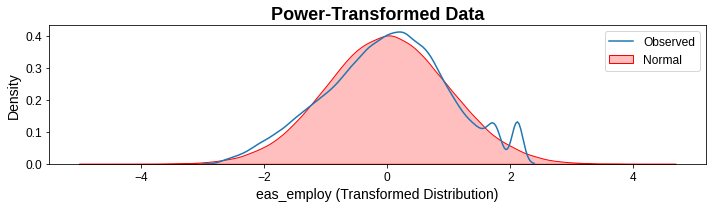

Using lambda (transform 'exponent') of 0.38421


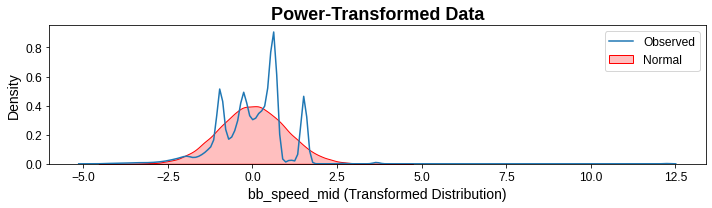

In [201]:
from sklearn.preprocessing import PowerTransformer

cols = ['eas_employ','bb_speed_mid']
pt = PowerTransformer(method='yeo-johnson')


for m in cols:
    s  = data[m] # s == series
    ts = pt.fit_transform(s.values.reshape(-1,1))
    print(f"Using lambda (transform 'exponent') of {pt.lambdas_[0]:0.5f}")
    
    ax = sns.kdeplot(ts.reshape(-1,))
    
    sns.kdeplot(normal_from_dist(ts), color='r', fill=True, ax=ax)
    plt.legend(loc='upper right', labels=['Observed', 'Normal'])
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_xlabel(m + " (Transformed Distribution)")
    if ax.get_xlim()[1] > 999999:
        plt.xticks(rotation=45)
    plt.title("Power-Transformed Data")
    plt.show();

In [202]:
data_stdd = data[['eas_employ','bb_speed_mid']]
cols = ['eas_employ','bb_speed_mid']
pt = PowerTransformer(method='yeo-johnson')

for c in data_stdd.columns.values:
    data_stdd[c] = pt.fit_transform(data_stdd[c].values.reshape(-1,1))
data_stdd.head()

,eas_employ,bb_speed_mid
E00000001,-1.24,0.49
E00000003,0.50,0.63
E00000005,0.22,-0.25
E00000007,1.64,-2.70
E00000010,-1.78,0.27


In [203]:
model_data_stdd = sm.OLS(endog=data_stdd[['eas_employ']], exog=sm.add_constant(data_stdd.drop(columns= ['eas_employ']))).fit()
model_data_stdd.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             eas_employ   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2977.
Date:                Mon, 16 Jan 2023   Prob (F-statistic):               0.00
Time:                        05:52:27   Log-Likelihood:            -2.2602e+05
No. Observations:              160329   AIC:                         4.520e+05
Df Residuals:                  160327   BIC:                         4.521e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2.396e-16      0.002   9.68e-14      1.000      -0.005       0.005
bb_speed_mid    -0.1350      0.002    -54.560      0.000      -0.140      -0.130
==============================================================================
Omnibus:                      942.583   Durbin-Watson:                   1.319
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              746.520
Skew:                          -0.089   Prob(JB):                    7.86e-163
Kurtosis:                       2.717   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [204]:
data2 = pd.merge(data_stdd, data.drop(columns=['eas_employ','bb_speed_mid']), left_index=True, right_index=True, how='inner')


In [205]:
data2.columns

Index(['eas_employ', 'bb_speed_mid', 'eas_total', 'eas_active_total',
       'eas_inactive_total', 'eas_unemploy_total', 'eas_unemploy',
       'eas_inactive', 'bb_speed_mean', 'bb_speed_ultrafast',
       'bb_speed_superfast', 'bb_speed_normal', 'ln_bb_speed_mean',
       'bb_speed_mid_ultrafast', 'bb_speed_mid_superfast',
       'bb_speed_mid_normal', 'ln_bb_speed_mid', 'type', 'REG_NAME', 'London',
       'NorthWest', 'YorkshireandTheHumber', 'NorthEast', 'WestMidlands',
       'EastMidlands', 'SouthWest', 'EastofEngland', 'SouthEast', 'Wales',
       'bb_lines_total', 'bb_lines_ultrafast', 'bb_lines_superfast',
       'bb_lines_normal', 'LSOA21CD', 'RUC11CD', 'ru', 'ru_urban', 'dp_total',
       'deptotal', 'undeptotal', 'deprived', 'undeprived', 'ethnicity_total',
       'minoritytotal', 'whitetotal', 'minority', 'white', 'nssec_total',
       'higher_managerial_per', 'lower_supervisory_per', 'semiroutine_per',
       'routine_per', 'longterm_unemployed_per', 'fulltime_students_pe

In [206]:
data_stdd2 = data2[['eas_employ', 'bb_speed_mid', 'eas_total', 
       'London', 'bb_lines_total', 'ru_urban', 'undeprived', 'white', 
       'cluster_id', 'edu_index', 'wfh',
       ]]

In [207]:
model_data_new = sm.OLS(endog=data_stdd2[['eas_employ']], exog=sm.add_constant(data_stdd2.drop(columns= ['eas_employ']))).fit()
model_data_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             eas_employ   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                 1.285e+04
Date:                Mon, 16 Jan 2023   Prob (F-statistic):               0.00
Time:                        05:52:30   Log-Likelihood:            -1.8031e+05
No. Observations:              160329   AIC:                         3.606e+05
Df Residuals:                  160318   BIC:                         3.608e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.1480      0.021   -101.534      0.000      -2.189      -2.107
bb_speed_mid      -0.0503      0.002    -24.549      0.000      -0.054      -0.046
eas_total         -0.0010   3.11e-05    -31.288      0.000      -0.001      -0.001
London            -0.0407      0.007     -5.715      0.000      -0.055      -0.027
bb_lines_total     0.0010   4.64e-05     22.249      0.000       0.001       0.001
ru_urban          -0.1959      0.005    -36.088      0.000      -0.207      -0.185
undeprived         4.7753      0.026    184.517      0.000       4.725       4.826
white              1.1038      0.013     84.997      0.000       1.078       1.129
cluster_id        -0.0063      0.006     -1.096      0.273      -0.018       0.005
edu_index         -0.0195      0.000    -55.643      0.000      -0.020      -0.019
wfh                0.8674      0.046     19.054      0.000       0.778       0.957
==============================================================================
Omnibus:                     4315.676   Durbin-Watson:                   1.760
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4827.589
Skew:                           0.383   Prob(JB):                         0.00
Kurtosis:                       3.369   Cond. No.                     9.74e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.74e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [208]:
print(model_data_new.summary())

                            OLS Regression Results                            
Dep. Variable:             eas_employ   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                 1.285e+04
Date:                Mon, 16 Jan 2023   Prob (F-statistic):               0.00
Time:                        05:52:30   Log-Likelihood:            -1.8031e+05
No. Observations:              160329   AIC:                         3.606e+05
Df Residuals:                  160318   BIC:                         3.608e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.1480      0.021   -101.

#### VIF

In [209]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [210]:
data_new = drop_column_using_vif_(data_stdd2.drop('eas_employ', axis=1)) 


VIF checked. No variables are dropped, so multicollinearity is not likely to be an issue to this model.

#### OLS by speed type

In [211]:
data_normal = data_stdd2[data2.bb_speed_normal==1]
data_super = data_stdd2[data2.bb_speed_superfast==1]
data_ultra = data_stdd2[data2.bb_speed_ultrafast==1]

In [212]:
model_data_normal = sm.OLS(endog=data_normal[['eas_employ']], exog=sm.add_constant(data_normal.drop(columns= ['eas_employ']))).fit()
model_data_normal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             eas_employ   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     174.7
Date:                Mon, 16 Jan 2023   Prob (F-statistic):          2.95e-303
Time:                        05:52:39   Log-Likelihood:                -4677.4
No. Observations:                3817   AIC:                             9377.
Df Residuals:                    3806   BIC:                             9446.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.8149      0.207    -13.613      0.000      -3.220      -2.410
bb_speed_mid      -0.0063      0.021     -0.296      0.768      -0.048       0.035
eas_total         -0.0004      0.000     -2.277      0.023      -0.001   -5.24e-05
London             0.1622      0.093      1.745      0.081      -0.020       0.344
bb_lines_total     0.0009      0.000      3.010      0.003       0.000       0.001
ru_urban          -0.0970      0.032     -3.059      0.002      -0.159      -0.035
undeprived         3.8008      0.188     20.193      0.000       3.432       4.170
white              2.1721      0.154     14.076      0.000       1.870       2.475
cluster_id        -0.0597      0.042     -1.425      0.154      -0.142       0.022
edu_index         -0.0198      0.002     -8.289      0.000      -0.024      -0.015
wfh                1.5476      0.315      4.910      0.000       0.930       2.165
==============================================================================
Omnibus:                       56.343   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.782
Skew:                           0.270   Prob(JB):                     6.33e-14
Kurtosis:                       3.303   Cond. No.                     7.92e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [213]:
model_data_super = sm.OLS(endog=data_super[['eas_employ']], exog=sm.add_constant(data_super.drop(columns= ['eas_employ']))).fit()
model_data_super.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             eas_employ   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                 1.262e+04
Date:                Mon, 16 Jan 2023   Prob (F-statistic):               0.00
Time:                        05:52:41   Log-Likelihood:            -1.7523e+05
No. Observations:              156292   AIC:                         3.505e+05
Df Residuals:                  156281   BIC:                         3.506e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.1403      0.021    -99.798      0.000      -2.182      -2.098
bb_speed_mid      -0.0572      0.002    -25.224      0.000      -0.062      -0.053
eas_total         -0.0010   3.21e-05    -31.045      0.000      -0.001      -0.001
London            -0.0425      0.007     -5.957      0.000      -0.057      -0.029
bb_lines_total     0.0010   4.84e-05     21.500      0.000       0.001       0.001
ru_urban          -0.1931      0.006    -34.692      0.000      -0.204      -0.182
undeprived         4.8026      0.026    183.837      0.000       4.751       4.854
white              1.0825      0.013     82.834      0.000       1.057       1.108
cluster_id        -0.0037      0.006     -0.643      0.520      -0.015       0.008
edu_index         -0.0195      0.000    -54.871      0.000      -0.020      -0.019
wfh                0.8550      0.046     18.525      0.000       0.765       0.945
==============================================================================
Omnibus:                     4285.898   Durbin-Watson:                   1.762
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4794.419
Skew:                           0.388   Prob(JB):                         0.00
Kurtosis:                       3.367   Cond. No.                     9.82e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.82e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [214]:
model_data_ultra = sm.OLS(endog=data_ultra[['eas_employ']], exog=sm.add_constant(data_ultra.drop(columns= ['eas_employ']))).fit()
model_data_ultra.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             eas_employ   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     15.56
Date:                Mon, 16 Jan 2023   Prob (F-statistic):           1.08e-20
Time:                        05:52:42   Log-Likelihood:                -247.39
No. Observations:                 220   AIC:                             516.8
Df Residuals:                     209   BIC:                             554.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -4.4812      1.198     -3.741      0.000      -6.842      -2.120
bb_speed_mid      -0.0052      0.013     -0.412      0.681      -0.030       0.020
eas_total         -0.0008      0.000     -2.522      0.012      -0.001      -0.000
London             0.3308      0.438      0.755      0.451      -0.533       1.195
bb_lines_total     0.0013      0.001      1.798      0.074      -0.000       0.003
ru_urban          -0.1926      0.172     -1.118      0.265      -0.532       0.147
undeprived         4.6332      0.804      5.761      0.000       3.048       6.219
white              4.0553      1.060      3.825      0.000       1.965       6.146
cluster_id        -0.0495      0.213     -0.232      0.817      -0.470       0.371
edu_index         -0.0307      0.009     -3.247      0.001      -0.049      -0.012
wfh                2.2213      1.127      1.970      0.050      -0.001       4.444
==============================================================================
Omnibus:                        0.051   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.975   Jarque-Bera (JB):                0.141
Skew:                           0.029   Prob(JB):                        0.932
Kurtosis:                       2.891   Cond. No.                     1.27e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### OLS by job type

In [215]:
data_managerial2 = data_stdd2[data_stdd2.cluster_id==0]
data_routine2 = data_stdd2[data_stdd2.cluster_id==1]

In [216]:
model_managerial = sm.OLS(endog=data_managerial2[['eas_employ']], exog=sm.add_constant(data_managerial2.drop(columns= ['eas_employ','cluster_id']))).fit()
model_managerial.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             eas_employ   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     4227.
Date:                Mon, 16 Jan 2023   Prob (F-statistic):               0.00
Time:                        05:52:47   Log-Likelihood:                -81919.
No. Observations:               75868   AIC:                         1.639e+05
Df Residuals:                   75858   BIC:                         1.639e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.1868      0.032    -37.537      0.000      -1.249      -1.125
bb_speed_mid      -0.0292      0.003    -10.739      0.000      -0.035      -0.024
eas_total         -0.0010   3.82e-05    -26.260      0.000      -0.001      -0.001
London            -0.1063      0.009    -11.524      0.000      -0.124      -0.088
bb_lines_total     0.0009   5.73e-05     16.563      0.000       0.001       0.001
ru_urban          -0.1445      0.007    -20.977      0.000      -0.158      -0.131
undeprived         3.6969      0.036    102.176      0.000       3.626       3.768
white              1.2996      0.022     59.320      0.000       1.257       1.343
edu_index         -0.0303      0.000    -70.704      0.000      -0.031      -0.029
wfh                1.2716      0.054     23.711      0.000       1.166       1.377
==============================================================================
Omnibus:                      673.378   Durbin-Watson:                   1.826
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              691.279
Skew:                           0.232   Prob(JB):                    7.78e-151
Kurtosis:                       3.054   Cond. No.                     8.89e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [217]:
model_routine = sm.OLS(endog=data_routine2[['eas_employ']], exog=sm.add_constant(data_routine2.drop(columns= ['eas_employ','cluster_id']))).fit()
model_routine.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             eas_employ   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     7312.
Date:                Mon, 16 Jan 2023   Prob (F-statistic):               0.00
Time:                        05:52:48   Log-Likelihood:                -95530.
No. Observations:               84461   AIC:                         1.911e+05
Df Residuals:                   84451   BIC:                         1.912e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.5915      0.028    -92.877      0.000      -2.646      -2.537
bb_speed_mid      -0.0574      0.003    -19.163      0.000      -0.063      -0.051
eas_total         -0.0007   5.07e-05    -13.309      0.000      -0.001      -0.001
London            -0.0056      0.012     -0.474      0.636      -0.029       0.018
bb_lines_total     0.0005   7.52e-05      6.855      0.000       0.000       0.001
ru_urban          -0.1954      0.009    -22.820      0.000      -0.212      -0.179
undeprived         4.8361      0.039    122.882      0.000       4.759       4.913
white              1.0624      0.017     62.920      0.000       1.029       1.096
edu_index         -0.0136      0.001    -22.263      0.000      -0.015      -0.012
wfh                3.3172      0.094     35.448      0.000       3.134       3.501
==============================================================================
Omnibus:                     5055.686   Durbin-Watson:                   1.759
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6440.163
Skew:                           0.578   Prob(JB):                         0.00
Kurtosis:                       3.702   Cond. No.                     1.39e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### (Without transform)OLS by speed type

In [218]:
data_normal2 = data[data.bb_speed_normal==1][['eas_employ', 'bb_speed_mid', 'eas_total', 
       'London', 'bb_lines_total', 'ru_urban', 'undeprived', 'white', 
       'cluster_id', 'edu_index', 'wfh',
       ]]
data_super2 = data[data.bb_speed_superfast==1][['eas_employ', 'bb_speed_mid', 'eas_total', 
       'London', 'bb_lines_total', 'ru_urban', 'undeprived', 'white', 
       'cluster_id', 'edu_index', 'wfh',
       ]]
data_ultra2 = data[data.bb_speed_ultrafast==1][['eas_employ', 'bb_speed_mid', 'eas_total', 
       'London', 'bb_lines_total', 'ru_urban', 'undeprived', 'white', 
       'cluster_id', 'edu_index', 'wfh',
       ]]

In [219]:
data_2 = data[['eas_employ', 'bb_speed_mid', 'eas_total', 
       'London', 'bb_lines_total', 'ru_urban', 'undeprived', 'white', 
       'cluster_id', 'edu_index', 'wfh',
       ]]

In [220]:
data_2.describe()

,eas_employ,bb_speed_mid,eas_total,London,bb_lines_total,ru_urban,undeprived,white,cluster_id,edu_index,wfh
count,"160,329.00","160,329.00","160,329.00","160,329.00","160,329.00","160,329.00","160,329.00","160,329.00","160,329.00","160,329.00","160,329.00"
mean,0.94,64.03,314.96,0.14,206.05,0.82,0.48,0.83,0.53,46.92,0.15
std,0.04,30.52,84.06,0.35,54.28,0.38,0.13,0.20,0.50,10.96,0.08
min,0.39,0.50,97.00,0.00,2.00,0.00,0.03,0.00,0.00,12.56,0.00
25%,0.93,45.90,265.00,0.00,176.00,1.00,0.38,0.78,0.00,39.13,0.08
50%,0.95,63.60,306.00,0.00,203.00,1.00,0.49,0.92,1.00,46.72,0.13
75%,0.97,78.10,354.00,0.00,230.00,1.00,0.57,0.97,1.00,53.95,0.19
max,1.00,"1,000.00","3,978.00",1.00,"1,571.00",1.00,0.90,1.00,1.00,94.93,0.69


In [221]:
model_data_all2 = sm.OLS(endog=data_2[['eas_employ']], exog=sm.add_constant(data_2.drop(columns= ['eas_employ']))).fit()
model_data_all2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             eas_employ   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                 1.313e+04
Date:                Mon, 16 Jan 2023   Prob (F-statistic):               0.00
Time:                        05:52:53   Log-Likelihood:             3.3175e+05
No. Observations:              160329   AIC:                        -6.635e+05
Df Residuals:                  160318   BIC:                        -6.634e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.8580      0.001    972.811      0.000       0.856       0.860
bb_speed_mid   -5.013e-05   2.62e-06    -19.169      0.000   -5.53e-05    -4.5e-05
eas_total      -6.657e-05   1.27e-06    -52.328      0.000   -6.91e-05   -6.41e-05
London             0.0034      0.000     11.789      0.000       0.003       0.004
bb_lines_total  9.279e-05   1.88e-06     49.474      0.000    8.91e-05    9.65e-05
ru_urban          -0.0074      0.000    -34.050      0.000      -0.008      -0.007
undeprived         0.2037      0.001    191.988      0.000       0.202       0.206
white              0.0480      0.001     90.686      0.000       0.047       0.049
cluster_id         0.0022      0.000      9.238      0.000       0.002       0.003
edu_index         -0.0011   1.44e-05    -78.905      0.000      -0.001      -0.001
wfh                0.0669      0.002     35.854      0.000       0.063       0.071
==============================================================================
Omnibus:                    61114.514   Durbin-Watson:                   1.666
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           671325.936
Skew:                          -1.523   Prob(JB):                         0.00
Kurtosis:                      12.550   Cond. No.                     9.87e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.87e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [222]:
data_new2 = drop_column_using_vif_(data_ultra2.drop('eas_employ', axis=1)) 


Dropping: London


In [223]:
model_data_normal2 = sm.OLS(endog=data_normal2[['eas_employ']], exog=sm.add_constant(data_normal2.drop(columns= ['eas_employ']))).fit()
model_data_normal2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             eas_employ   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     216.3
Date:                Mon, 16 Jan 2023   Prob (F-statistic):               0.00
Time:                        05:52:54   Log-Likelihood:                 7723.7
No. Observations:                3817   AIC:                        -1.543e+04
Df Residuals:                    3806   BIC:                        -1.536e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.8214      0.008    105.686      0.000       0.806       0.837
bb_speed_mid   -6.235e-05    7.8e-05     -0.799      0.424      -0.000    9.06e-05
eas_total       -3.45e-05   6.44e-06     -5.356      0.000   -4.71e-05   -2.19e-05
London             0.0137      0.004      3.810      0.000       0.007       0.021
bb_lines_total  7.816e-05   1.13e-05      6.923      0.000     5.6e-05       0.000
ru_urban          -0.0040      0.001     -3.210      0.001      -0.006      -0.002
undeprived         0.1690      0.007     23.131      0.000       0.155       0.183
white              0.1008      0.006     16.829      0.000       0.089       0.113
cluster_id         0.0009      0.002      0.571      0.568      -0.002       0.004
edu_index         -0.0012   9.25e-05    -13.433      0.000      -0.001      -0.001
wfh                0.1048      0.012      8.562      0.000       0.081       0.129
==============================================================================
Omnibus:                     2480.786   Durbin-Watson:                   1.773
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            94180.130
Skew:                          -2.546   Prob(JB):                         0.00
Kurtosis:                      26.796   Cond. No.                     7.89e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [224]:
model_data_super2 = sm.OLS(endog=data_super2[['eas_employ']], exog=sm.add_constant(data_super2.drop(columns= ['eas_employ']))).fit()
model_data_super2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             eas_employ   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                 1.293e+04
Date:                Mon, 16 Jan 2023   Prob (F-statistic):               0.00
Time:                        05:52:55   Log-Likelihood:             3.2385e+05
No. Observations:              156292   AIC:                        -6.477e+05
Df Residuals:                  156281   BIC:                        -6.476e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.8595      0.001    948.738      0.000       0.858       0.861
bb_speed_mid   -8.109e-05   3.56e-06    -22.783      0.000   -8.81e-05   -7.41e-05
eas_total      -6.926e-05   1.32e-06    -52.651      0.000   -7.18e-05   -6.67e-05
London             0.0034      0.000     11.427      0.000       0.003       0.004
bb_lines_total  9.886e-05   1.98e-06     50.047      0.000     9.5e-05       0.000
ru_urban          -0.0067      0.000    -29.416      0.000      -0.007      -0.006
undeprived         0.2051      0.001    191.298      0.000       0.203       0.207
white              0.0464      0.001     86.643      0.000       0.045       0.047
cluster_id         0.0024      0.000     10.000      0.000       0.002       0.003
edu_index         -0.0011   1.46e-05    -77.675      0.000      -0.001      -0.001
wfh                0.0656      0.002     34.643      0.000       0.062       0.069
==============================================================================
Omnibus:                    57687.659   Durbin-Watson:                   1.672
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           591073.831
Skew:                          -1.485   Prob(JB):                         0.00
Kurtosis:                      12.053   Cond. No.                     9.96e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.96e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [225]:
model_data_ultra2 = sm.OLS(endog=data_ultra2[['eas_employ']], exog=sm.add_constant(data_ultra2.drop(columns= ['eas_employ','London']))).fit()
model_data_ultra2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             eas_employ   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     25.59
Date:                Mon, 16 Jan 2023   Prob (F-statistic):           2.02e-29
Time:                        05:52:55   Log-Likelihood:                 445.43
No. Observations:                 220   AIC:                            -870.9
Df Residuals:                     210   BIC:                            -836.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.7450      0.045     16.585      0.000       0.656       0.834
bb_speed_mid   -7.686e-06   7.13e-06     -1.078      0.282   -2.17e-05    6.37e-06
eas_total      -7.323e-05    1.3e-05     -5.646      0.000   -9.88e-05   -4.77e-05
bb_lines_total  8.141e-05   2.88e-05      2.826      0.005    2.46e-05       0.000
ru_urban          -0.0074      0.007     -0.989      0.324      -0.022       0.007
undeprived         0.1164      0.034      3.387      0.001       0.049       0.184
white              0.2223      0.034      6.582      0.000       0.156       0.289
cluster_id         0.0045      0.009      0.499      0.618      -0.013       0.023
edu_index         -0.0018      0.000     -4.457      0.000      -0.003      -0.001
wfh                0.2583      0.043      6.001      0.000       0.173       0.343
==============================================================================
Omnibus:                      213.084   Durbin-Watson:                   2.103
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9007.363
Skew:                          -3.520   Prob(JB):                         0.00
Kurtosis:                      33.546   Cond. No.                     1.59e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""